# **Aplicaciones en Tecnologías del Lenguaje - Práctica Temas 1 y 2**
## Notebook 2 - ML Baselines
### Student: Alvarez Lacasa, Lucas Alfredo

In this notebook, we will focus on defining some baselines for our task using lightweight Machine Learning models.

Specifically, we will address tasks such as:
- **Text representation in vector spaces**: Bag of Words (tf, tf-idf) combined with feature selection methods like `n-grams` or `chi-squared`.
- **Training, validation, and testing of some algorithms**.
- **Performance evaluation**, considering the task binary classification.
  We will use `macro F1` as the primary evaluation metric, but we will also report `accuracy`, `precision`, and `recall`.

⚠️ Attempting to cover all possible combinations of datasets, algorithms, text representations, and feature selection methods is unrealistic given the goal of completing this project in a month. For this reason, I will significantly narrow down the experiments I conduct, relying on intuition and previous results to decide how to proceed. I will not perform an in-depth hyperparameter search for each algorithm. I much rather prefer to spend a bit extra time on the following notebook, which will consist of fine-tuning of transformed-based encoders.
  

# Global Imports

Imports are declared on this first section of the notebook.

In [10]:
import abc
import itertools
import os
import random
from dataclasses import dataclass
from enum import StrEnum

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit, BaseCrossValidator, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# Functions and Auxiliary classes

I will define a set of utility functions and classes to avoid code duplication, making the notebook more maintainable and easier to re-execute. I believe this is generally a good practice, especially in longer notebooks, to isolate code execution in a way that reduces the likelihood of errors.

The vast majority of utility functions and classes (regardless of which section of the index they belong to) will be listed here for the sake of simplicity and to make it easier to reload the notebook during development.

In [11]:
"""
=========================
Route resolution class

EDIT THIS CLASS depending on where you will be running this notebook!
=========================
"""

COLAB_BASE_MOUNT_POINT: str = "/content/drive"


@dataclass
class RouteConfig:
    notebook_name: str
    run_in_colab: bool = False
    # TODO: Change this to your base Colab path!!! =========>
    colab_base_mount_point: str = COLAB_BASE_MOUNT_POINT
    colab_practice_base_dir: str = f"{COLAB_BASE_MOUNT_POINT}/My Drive/UNED/master_nlp/AplicacionesNLP/Tema_2/challenge"
    local_practice_base_dir: str = "/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge"
    # ======================================================>
    exp_output_rel_folder_path: str = "experiment_output"


class RouteResolver:
    """ This object abstracts the retrieval of the files used in this notebook by only editing the RouteConfig class received """

    def __init__(self, route_config: RouteConfig) -> None:
        if route_config.run_in_colab:
            # Import and mount into the base mount path for Google Colab
            from google.colab import drive
            drive.mount(route_config.colab_base_mount_point)

        self._config: RouteConfig = route_config

        # Create experiment output folder for this notebook
        exp_output_notebook_folder: str = self.current_exp_output_folder()
        if not os.path.isdir(exp_output_notebook_folder):
            print(f"Experiment output folder for this notebook does not exist. Creating...")
            os.mkdir(exp_output_notebook_folder)

    def base_folder_path(self) -> str:
        """Returns the base path depending if you're running in Colab or not"""
        return self._config.colab_practice_base_dir if self._config.run_in_colab else self._config.local_practice_base_dir

    def get_exp_output_folder(self) -> str:
        """Returns the path to the experiment outputs folder"""
        return os.path.join(self.base_folder_path(), self._config.exp_output_rel_folder_path)

    def get_exp_output_notebook_folder(self, flow_number: int) -> str:
        """Given flow number if returns the experiment output folder for it"""
        notebook_idx_2_name: dict[int, str] = {
            1: "1_data_exploration",
            2: "2_ml_baselines",
            3: "3_dl_approaches",
            4: "4_results_and_conclusions",
        }
        notebook_name: str = notebook_idx_2_name[flow_number]
        exp_output_notebook_folder: str = os.path.join(self.get_exp_output_folder(), notebook_name)
        validate_condition(condition=os.path.isdir(exp_output_notebook_folder),
                           msg=f"Can't find experiment output for flow: {notebook_name}")
        return exp_output_notebook_folder

    def current_exp_output_folder(self) -> str:
        """Returns experiment output folder for current notebook being ran"""
        return os.path.join(self.get_exp_output_folder(), self._config.notebook_name)

    def dump_registered_paths(self) -> None:
        running_env: str = "COLAB" if self._config.run_in_colab else "LOCAL"
        print("Registered application paths ========")
        print(f"Running environment: {running_env}")
        print(f"Experiment output for this notebook is located in: {self.current_exp_output_folder()}")

In [12]:
"""
=========================================
General utility functions
=========================================
"""


def validate_condition(condition: bool, msg: str, exc_type: type[Exception] = ValueError) -> None:
    """
    If condition is not met, it will raise a ValueError with the arguments provided
    :param condition: condition to validate
    :param msg: string to display in the error
    :param exc_type: type of exception we want to raise. ValueError by default
    :return: ValueError in case condition is not met, None otherwise
    """
    if not condition:
        raise exc_type(msg)


def create_dir_if_not_exists(folder: str) -> None:
    # Create a directory if it does not exist already
    if not os.path.isdir(folder):
        os.mkdir(folder)


class IberAuTextificationLabel(StrEnum):
    HUMAN: str = "human"
    MGT: str = "machine"


class IberAuTexTificationConfig:
    """ Helper class to manage labels info for our datasets """

    def __init__(self):
        self.binary_labels: list[str] = [IberAuTextificationLabel.HUMAN.value,
                                         IberAuTextificationLabel.MGT.value]

    def map_to_label_str(self, label: int) -> str:
        return self.index2label()[label]

    def index2label(self) -> dict[int, str]:
        return {idx: l for idx, l in enumerate(self.binary_labels)}

In [13]:
"""
===========================
Training and validation
===========================
"""


def prepare_data_for_training(dataset_folder: str, label_field: str = "label", content_field: str = "text",
                              convert_labels_to_str: bool = True) -> dict[
    str, list[str]]:
    """ 
    Receives the dataset folder, loads the files for training, validation and test and returns a dictionary that
    goes from the name of set and the value (x or y) to each of the values.
    
    No deduplication is executed, as datasets are properly crafted in the previous notebook
    """
    set_names: list[str] = ["train", "val", "test"]
    set_paths: list[str] = [os.path.join(dataset_folder, "train.tsv.gzip"),
                            os.path.join(dataset_folder, "val.tsv.gzip"),
                            os.path.join(dataset_folder, "test.tsv.gzip")]
    result: dict[str, list[str]] = {}
    ds_config: IberAuTexTificationConfig = IberAuTexTificationConfig()

    for set_name, set_path in zip(set_names, set_paths):
        set_df: pd.DataFrame = pd.read_csv(set_path, quotechar='"', header=0, sep="\t", compression="gzip")
        result[f"x_{set_name}"] = list(set_df[content_field])
        labels: list = list(set_df[label_field]) if not convert_labels_to_str else [ds_config.map_to_label_str(l) for l
                                                                                    in list(set_df[label_field])]
        result[f"y_{set_name}"] = labels
        print(f"Total elements for {set_name}: {len(set_df)}")

    return result

In [14]:
"""
===========================
Visualization functions
===========================
"""


def plot_learning_curve(estimator: BaseEstimator,
                        title: str,
                        X,
                        y,
                        ylim: tuple[int, int] | None = None,
                        cv: int | BaseCrossValidator = 5,
                        train_sizes=np.linspace(.1, 1.0, 5)) -> None:
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """

    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    if ylim:
        plt.ylim(ylim)
    plt.title(title)


def plot_confusion_matrix(cm, classes: list[str],
                          normalize: bool = False,
                          title: str = 'Confusion matrix',
                          cmap=plt.cm.Blues) -> None:
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    cm: confusion_matrix from scikit_learn.metrics
    classes: array with the classes
    title: the title to put on the chart
    cmap: the color palette to use
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Route Resolution

We will use a `RouteResolver` class to handle path resolution, isolating that information in one place so that it can be modified easily from a single point in the notebook.

Check the output of the following cell if you plan to re-run the notebook to ensure that the paths are pointing to the correct locations.
This time, I set `run_in_colab=False` since I was able to train the Machine Learning models on my personal laptop without needing a GPU.

In [15]:
# Routes
route_resolver: RouteResolver = RouteResolver(
    RouteConfig(run_in_colab=False, notebook_name="2_ml_baselines"))
route_resolver.dump_registered_paths()

Registered application paths ========
Running environment: LOCAL
Experiment output for this notebook is located in: /home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/2_ml_baselines


# Datasets Generated in `1_data_exploration`

We will define the paths to the previously generated datasets so that we can use them in this notebook.

In [16]:
notebook1_output_folder: str = route_resolver.get_exp_output_notebook_folder(1)
dataset_v1_folder: str = os.path.join(notebook1_output_folder, "v1")

# ML based algorithms for IberAuTextification

According to [their site](https://sites.google.com/view/iberautextification/evaluation?authuser=0), these are the models they have as baselines:

### Baselines

A set of classical machine learning models and pre-trained deep learning models will be used as baselines:

#### Classical Machine Learning:
- **Logistic Regression** with bag of n-grams at **word and character levels**.
- **Low-Dimensionality Statistical Embeddings (LDSE)** (Rangel et al., 2018).
- **Logistic Regression** with **readability features**.

#### Pre-trained Large Language Models:
- **Symanto Brain** with multilingual encoders (**zero and few-shot**).
- **XLM-RoBERTa** (Conneau et al., 2019).
- **MDeBERTa** (He et al., 2021).
- **Multilingual E5** (Liang et al., 2022).
- **LLMixTic** (Sarvazyan et al., 2024) – *Winner of SemEval 2024 Task 8 (to be published).*

#### Functional Baselines:
- **Random baseline**.
- **Majority baseline**.

---

All these baselines will use **default hyperparameters**, allowing participants to either:
- Explore **different hyperparameter configurations** of these models, or
- Investigate **new approaches and models**.

**Both classical machine learning and modern deep learning approaches are encouraged and welcome.**

In our case, we will try some ML based approaches in this notebook. Particularly, I will explore:
- Naive Bayes
- Logistic Regression


Let's start by coding some classes to help ourselves out!.

In [17]:
class ClassifierBase(abc.ABC):
    """ 
    Abstract class that defines an interface all classifiers must meet (both non-dl and deep learning ones).
    If properly implemented, we could use any of the classifier interchangeably in future tests.
    """

    @abc.abstractmethod
    def train(self, x_train: list[str], y_train: list[str], x_val: list[str], y_val: list[str]) -> None:
        pass

    @abc.abstractmethod
    def predict(self, x_test: list[str]) -> list:
        pass

    def _set_random_seeds(self, random_seed: int) -> None:
        """ Sets random seeds to a given value, so results can be reproduced """
        # tf.random.set_seed(random_seed)
        np.random.seed(random_seed)
        random.seed(random_seed)


class MLClassifier(ClassifierBase):
    def __init__(self,
                 estimator: BaseEstimator,
                 vectorizer: CountVectorizer,
                 optimization_grid: dict | None = None,
                 feat_selector: SelectKBest | None = None,
                 verbosity: int = 5) -> None:
        self._estimator: BaseEstimator = estimator
        self._vectorizer: CountVectorizer = vectorizer
        self._feat_selector: SelectKBest = feat_selector
        self._optimization_grid: dict = {} if optimization_grid is None else optimization_grid
        self._label_encoder: LabelEncoder = LabelEncoder()
        self._verbosity = verbosity

    def train(self, x_train: list[str], y_train: list[str], x_val: list[str], y_val: list[str]) -> None:
        """
        Trains classifier using validation from the given set
        :param x_train: training documents.
        :param y_train: training labels.
        :param x_val: validation documents.
        :param y_val: validation labels.
        :return:
        """
        x_all: list[str] = x_train + x_val
        y_all: list[str] = y_train + y_val

        print("Training feature extractor on x_train...")
        x_vec = self._vectorizer.fit_transform(x_all)
        print("Feature extractor trained!\n")

        if self._feat_selector:
            print("Training feature selector on vectorized x_train...")
            x_vec = self._feat_selector.fit_transform(x_vec, y_all)
            print("Feature selector trained!\n")

        print("Training label encoder on y_train")
        self._label_encoder.fit(y_all)
        encoded_y_train: list = self._label_encoder.transform(y_all)
        print("Label encoder trained!\n")

        # Use the predefined split for validation! Don't do cross-validation
        # Create an array that indicates the split: -1 for training, 0 for validation
        test_fold = np.concatenate((np.full(len(x_train), -1, dtype=int), np.zeros(len(x_val), dtype=int)))
        ps: PredefinedSplit = PredefinedSplit(test_fold)

        # Perform GridSearchCV with the predefined split
        self._classifier: GridSearchCV = GridSearchCV(estimator=self._estimator,
                                                      param_grid=self._optimization_grid,
                                                      cv=ps,
                                                      error_score=0.0,
                                                      n_jobs=-1,
                                                      verbose=self._verbosity)
        print(f"Training classifier with predefined split given by the validation set")
        self._classifier.fit(X=x_vec, y=encoded_y_train)
        print(f"Best estimator is: {self._classifier.best_estimator_}")
        print("Model trained correctly\n")

        # Scores on validation set
        self._plot_validation_scores()
        # Learning curve
        self._plot_learning_curve(x_vec=x_vec, encoded_y_train=encoded_y_train, cv=ps)

    def _plot_validation_scores(self) -> None:
        print("Plotting val-scores for each grid configuration")
        means: list[float] = self._classifier.cv_results_['mean_test_score']
        stds: list[float] = self._classifier.cv_results_['std_test_score']
        print(self._classifier.cv_results_)
        for mean, std, params in sorted(zip(means, stds, self._classifier.cv_results_['params']), key=lambda x: -x[0]):
            print("Accuracy: %0.3f (+/-%0.03f) for params: %r \n" % (mean, std * 2, params))
        print()

    def _plot_learning_curve(self, x_vec: list, encoded_y_train: list, cv: BaseCrossValidator) -> None:
        print("Plotting Learning curve for the best estimator...")
        title: str = 'Learning Curves (' + str(self._estimator.__class__).replace("'>", "").split(".")[-1] + ' )'
        plot_learning_curve(estimator=self._classifier.best_estimator_,
                            title=title,
                            X=x_vec,
                            y=encoded_y_train,
                            cv=cv)
        plt.show()

    def predict(self, x_test: list[str]) -> list[str]:
        # Apply prediction on several samples. Model must have been trained first.
        x_test_vec = self._vectorizer.transform(x_test)
        if self._feat_selector:
            x_test_vec = self._feat_selector.transform(x_test_vec)
        y_pred_int: list[int] = self._classifier.best_estimator_.predict(x_test_vec)
        y_pred: list[str] = self._label_encoder.inverse_transform(y_pred_int)

        return y_pred

    def label_encoder_classes(self) -> list[str]:
        return self._label_encoder.classes_

    def predict_with_report(self, x_test: list[str], y_true: list[str]) -> None:
        y_pred: list[str] = self.predict(x_test=x_test)

        print("TEST SET REPORT (BINARY-CLASS) =================================")
        label_classes_binary: list[str] = self.label_encoder_classes()
        cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=label_classes_binary)
        plot_confusion_matrix(cm, classes=label_classes_binary, title="Confusion matrix for binary labels")
        print(classification_report(y_true=y_true,
                                    y_pred=y_pred,
                                    target_names=label_classes_binary,
                                    digits=4))
        print(f"Test Accuracy: {round(accuracy_score(y_true, y_pred), 4)}")
        print(f"Test macro-F1: {round(f1_score(y_true=y_true, y_pred=y_pred, average='macro'), 4)}")
        print("\n\n")

    @property
    def classifier(self) -> GridSearchCV:
        return self._classifier

    @property
    def label_encoder(self) -> LabelEncoder:
        return self._label_encoder

    @property
    def best_estimator(self) -> BaseEstimator | None:
        """ Requires model to have been trained first """
        return self._classifier.best_estimator_

## Naive Bayes

We will use [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for this.

According to the scikit-learn documentation, this is the list of parameters that we could explore:

```
- alpha: float or array-like of shape (n_features,), default=1.0
  Additive (Laplace/Lidstone) smoothing parameter (set alpha=0 and force_alpha=True for no smoothing).

- force_alpha: bool, default=False
  If False and alpha is less than 1e-10, it will set alpha to 1e-10. If True, alpha will remain unchanged.
  This may cause numerical errors if alpha is too close to 0.
  New in version 1.2.
  Deprecated since version 1.2: The default value of force_alpha will change to True in v1.4.

- fit_prior: bool, default=True
  Whether to learn class prior probabilities or not. If False, a uniform prior will be used.

- class_prior: array-like of shape (n_classes,), default=None
  Prior probabilities of the classes. If specified, the priors are not adjusted according to the data.
```

I don’t see much value in exploring any of these parameters, as `alpha` is generally set to 1.0, and the priors (`fit_prior` and `class_prior`) can be adjusted based on the data we provide.

We will perform a quick initial test to ensure that the previously used code is working correctly.

In [18]:
# We can see the parameters and their defaults fairly easily with the following command
MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

In [33]:
x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_v1_folder)

x_y_data["y_test"][:10]

Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290


['machine',
 'machine',
 'machine',
 'human',
 'machine',
 'human',
 'human',
 'human',
 'machine',
 'machine']

TRAINING with dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' =======================
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Training feature extractor on x_train...
Feature extractor trained!

Training label encoder on y_train
Label encoder trained!

Training classifier with predefined split given by the validation set
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best estimator is: Mul

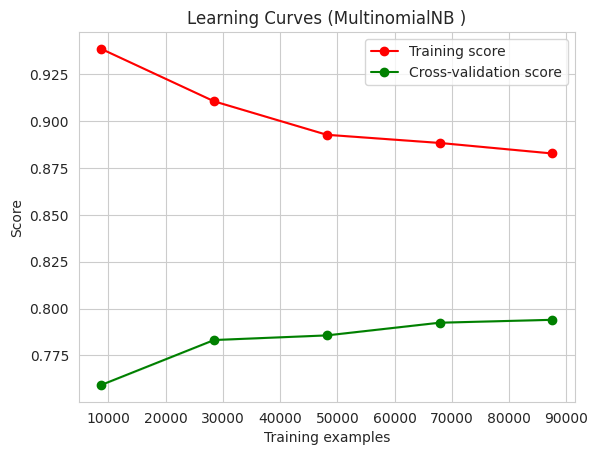

TEST SET REPORT (BINARY-CLASS) =================================


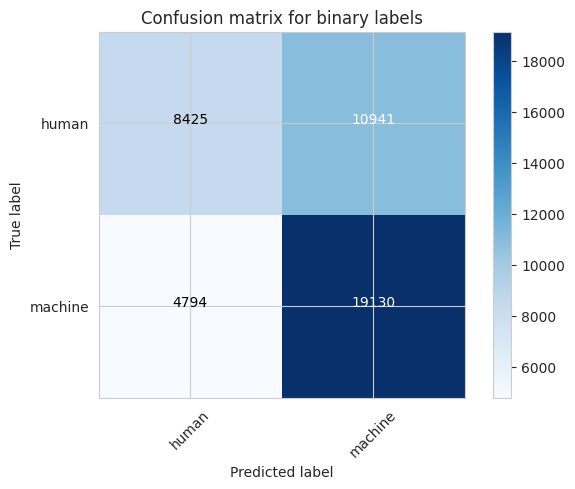

              precision    recall  f1-score   support

       human     0.6373    0.4350    0.5171     19366
     machine     0.6362    0.7996    0.7086     23924

    accuracy                         0.6365     43290
   macro avg     0.6368    0.6173    0.6128     43290
weighted avg     0.6367    0.6365    0.6229     43290

Test Accuracy: 0.6365
Test macro-F1: 0.6128





In [34]:
for dataset_folder in [dataset_v1_folder]:
    # TRAINING & VALIDATION ===============>
    print(f"TRAINING with dataset: '{dataset_folder}' =======================")
    x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

    count_vectorizer: CountVectorizer = CountVectorizer(analyzer="word")
    print(f"Vectorizer class used: '{type(count_vectorizer)}' with config: {count_vectorizer.get_params()}")

    model: MLClassifier = MLClassifier(estimator=MultinomialNB(),
                                       vectorizer=count_vectorizer,
                                       optimization_grid=None,
                                       feat_selector=None)

    x_train, y_train, x_val, y_val, x_test, y_test = (x_y_data["x_train"],
                                                      x_y_data["y_train"],
                                                      x_y_data["x_val"],
                                                      x_y_data["y_val"],
                                                      x_y_data["x_test"],
                                                      x_y_data["y_test"])

    model.train(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)
    # TESTING =================>
    model.predict_with_report(x_test=x_test, y_true=y_test)

With this quick test, we can make sure that our code works!. A few details:
- We get a **macro-f1 of 61.28%**. which is okay-ish for an initial test.
- We can see that the model predicts many times "machine" for "human" generated texts.

We'll leave the same model for now, and play a bit with tf-idf and n-grams.

In [37]:
train_conditions: list[dict] = [
    {
        "name": "tf-1",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 1))
    },
    {
        "name": "tf-2",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 2))
    },
    {
        "name": "tf-3",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 3))
    },
    {
        "name": "tf-idf-1",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 1))
    },
    {
        "name": "tf-idf-2",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 2))
    },
    {
        "name": "tf-idf-3",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 3))
    }
]

TRAINING condition: 'tf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Training feature extractor on x_train...
Feature extractor trained!

Training label encoder on y_train
Label encoder trained!

Training classifier with predefined split given by the validation set
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best 

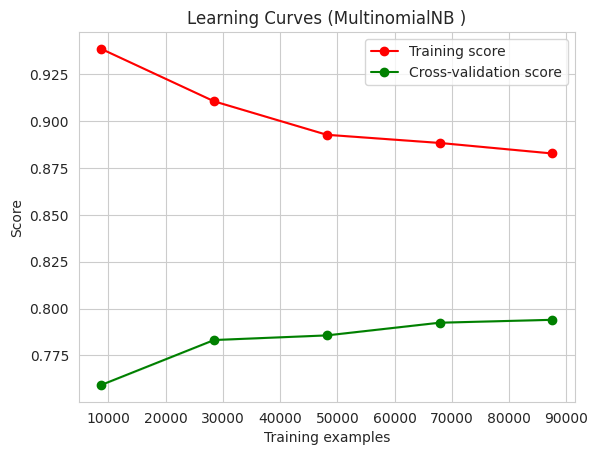

TEST SET REPORT (BINARY-CLASS) =================================


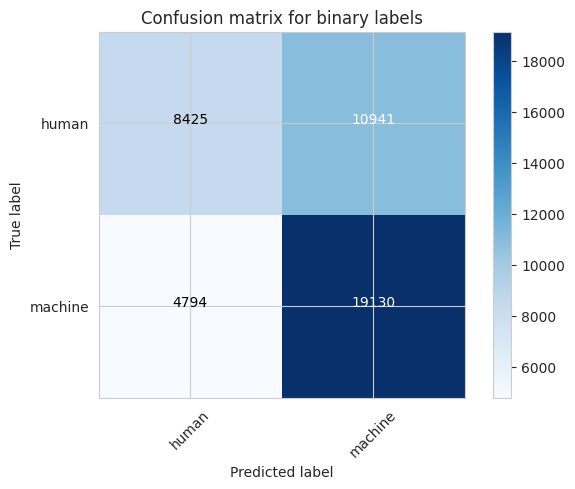

              precision    recall  f1-score   support

       human     0.6373    0.4350    0.5171     19366
     machine     0.6362    0.7996    0.7086     23924

    accuracy                         0.6365     43290
   macro avg     0.6368    0.6173    0.6128     43290
weighted avg     0.6367    0.6365    0.6229     43290

Test Accuracy: 0.6365
Test macro-F1: 0.6128



TRAINING condition: 'tf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'preprocessor': None, 'stop_w

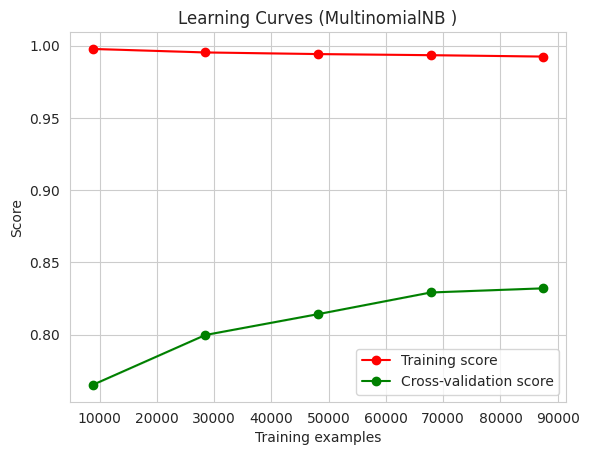

TEST SET REPORT (BINARY-CLASS) =================================


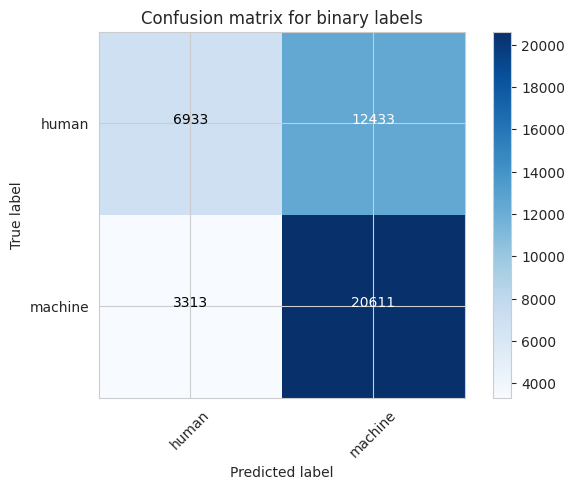

              precision    recall  f1-score   support

       human     0.6767    0.3580    0.4683     19366
     machine     0.6237    0.8615    0.7236     23924

    accuracy                         0.6363     43290
   macro avg     0.6502    0.6098    0.5959     43290
weighted avg     0.6474    0.6363    0.6094     43290

Test Accuracy: 0.6363
Test macro-F1: 0.5959



TRAINING condition: 'tf-3' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 3), 'preprocessor': None, 'stop_w

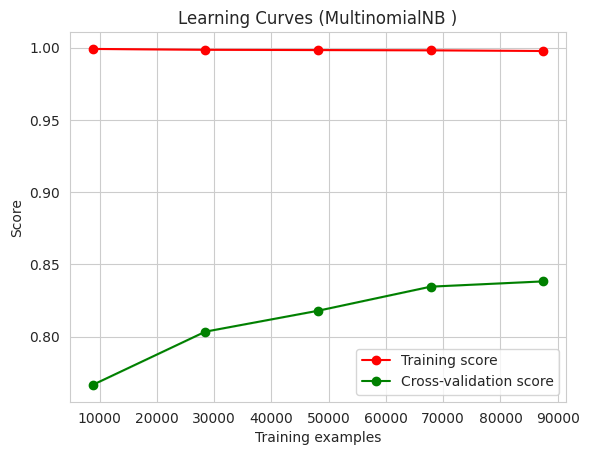

TEST SET REPORT (BINARY-CLASS) =================================


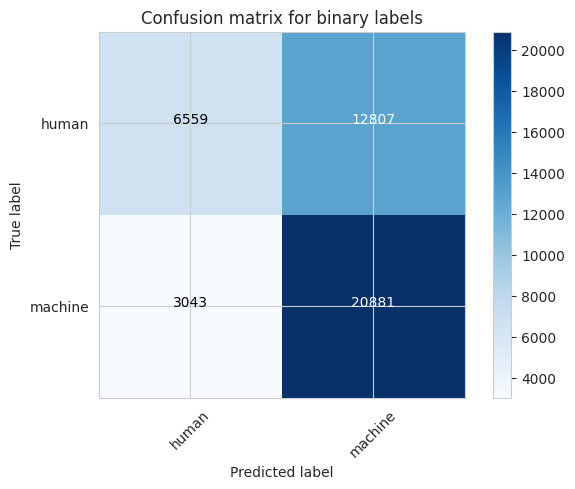

              precision    recall  f1-score   support

       human     0.6831    0.3387    0.4528     19366
     machine     0.6198    0.8728    0.7249     23924

    accuracy                         0.6339     43290
   macro avg     0.6515    0.6057    0.5889     43290
weighted avg     0.6481    0.6339    0.6032     43290

Test Accuracy: 0.6339
Test macro-F1: 0.5889



TRAINING condition: 'tf-idf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preproce

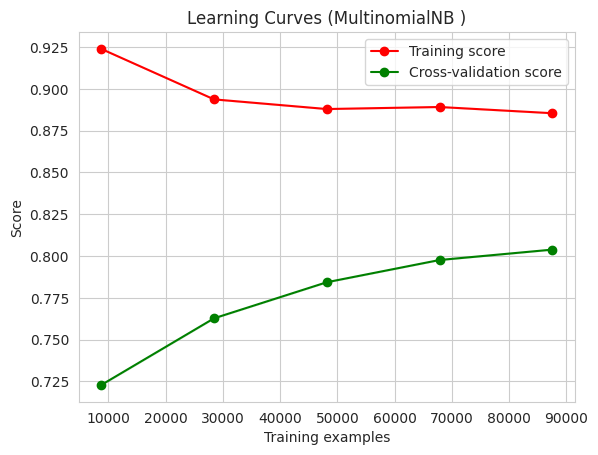

TEST SET REPORT (BINARY-CLASS) =================================


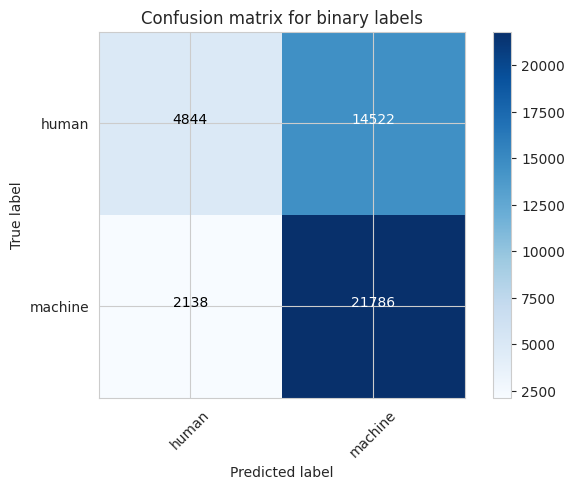

              precision    recall  f1-score   support

       human     0.6938    0.2501    0.3677     19366
     machine     0.6000    0.9106    0.7234     23924

    accuracy                         0.6152     43290
   macro avg     0.6469    0.5804    0.5455     43290
weighted avg     0.6420    0.6152    0.5643     43290

Test Accuracy: 0.6152
Test macro-F1: 0.5455



TRAINING condition: 'tf-idf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'norm': 'l2', 'preproce

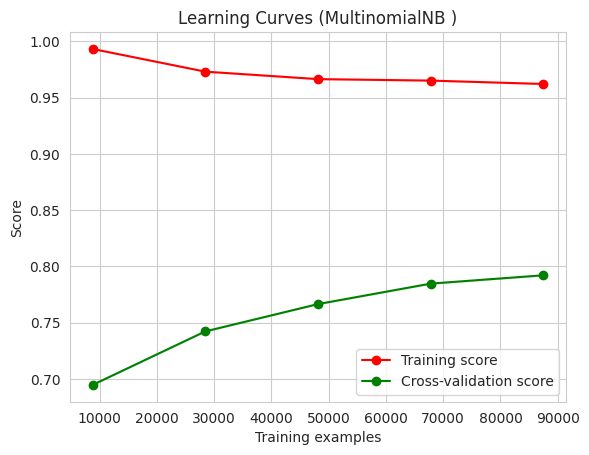

TEST SET REPORT (BINARY-CLASS) =================================


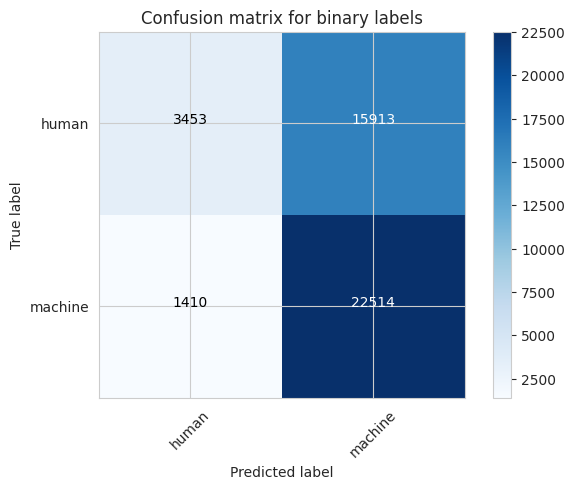

              precision    recall  f1-score   support

       human     0.7101    0.1783    0.2850     19366
     machine     0.5859    0.9411    0.7222     23924

    accuracy                         0.5998     43290
   macro avg     0.6480    0.5597    0.5036     43290
weighted avg     0.6414    0.5998    0.5266     43290

Test Accuracy: 0.5998
Test macro-F1: 0.5036



TRAINING condition: 'tf-idf-3' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 3), 'norm': 'l2', 'preproce

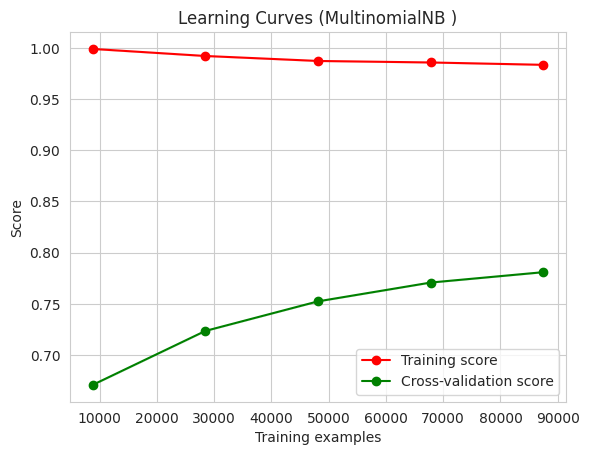

TEST SET REPORT (BINARY-CLASS) =================================


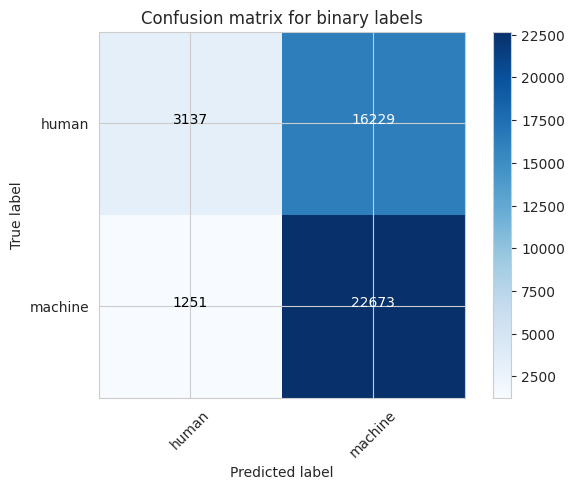

              precision    recall  f1-score   support

       human     0.7149    0.1620    0.2641     19366
     machine     0.5828    0.9477    0.7218     23924

    accuracy                         0.5962     43290
   macro avg     0.6489    0.5548    0.4929     43290
weighted avg     0.6419    0.5962    0.5170     43290

Test Accuracy: 0.5962
Test macro-F1: 0.4929





In [38]:
for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")
    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_v1_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        model: MLClassifier = MLClassifier(estimator=MultinomialNB(),
                                           vectorizer=vectorizer,
                                           optimization_grid=None,
                                           feat_selector=None)

        x_train, y_train, x_val, y_val, x_test, y_test = (x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                                                          x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

        model.train(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)
        # TESTING =================>
        model.predict_with_report(x_test=x_test, y_true=y_test)

We can see that the performance obtained in this case is worse than what we get with "tf" and using unigrams. The model seems to start overfitting once we add n-grams. It's a bit surprising that with "tf" it works better than with "tf-idf".

In any case, since this is a baseline, we'll try some additional algorithms.

## Logistic Regression (MaxEnt)

We will study the behavior of probabilistic classifiers based on [Maximum Entropy](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (MaxEnt), which are also well-suited for text classification.

### Parameters to Explore
Based on my research, the most commonly explored parameters are:
- **penalty:** It is a regularization parameter that penalizes the model’s weights to reduce overfitting.
- **C:** Similar to SVC, smaller values of `C` correspond to stronger regularization.
- **solver:** The optimization algorithm to use. The default is `lbfgs`. For small datasets, it is also recommended to try `liblinear`.
- **max_iter:** The maximum number of iterations allowed for the solvers to converge. So far, we haven't had to deal with this much (Naive Bayes doesn't have this parameter, and in SVC it defaults to `-1`). Here, we will try tuning it a bit.

*During the experiments, I gradually increased `max_iter` until the warning indicating that `lbfgs` had not converged within the allowed number of iterations disappeared.*

In [39]:
# We can see the parameters and their defaults fairly easily with the following command
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [27]:
max_ent_grid = [
    {'penalty': [None], "solver": ["lbfgs"], "max_iter": [500]},  # the simplest
    {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "solver": ["lbfgs"], "max_iter": [500]},
    {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "solver": ["liblinear"], "max_iter": [500]}
]

TRAINING condition: 'tf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Training feature extractor on x_train...
Feature extractor trained!

Training label encoder on y_train
Label encoder trained!

Training classifier with predefined split given by the validation set
Fitting 1 folds for each of 22 candidates, totalling 22 fits
Bes

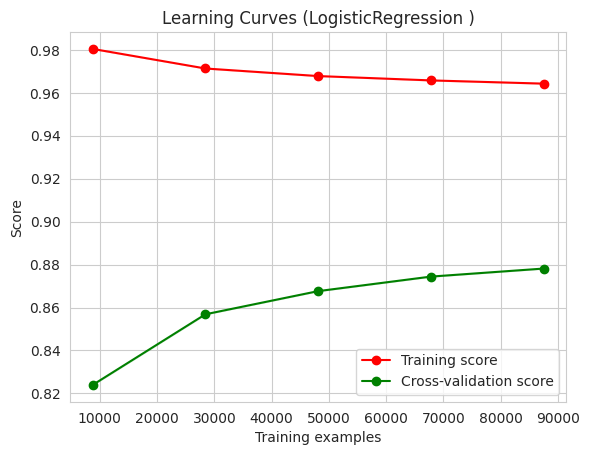

TEST SET REPORT (BINARY-CLASS) =================================


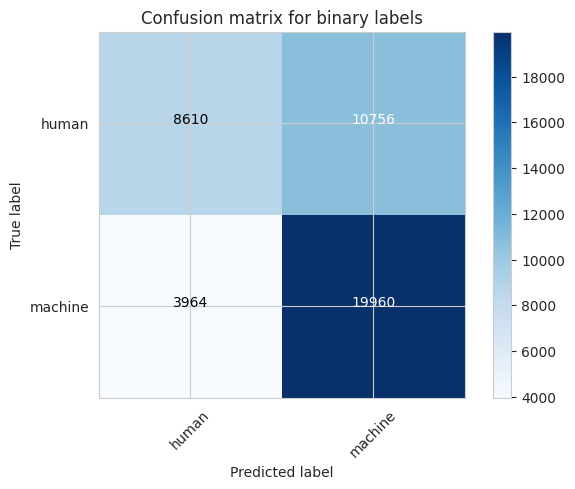

              precision    recall  f1-score   support

       human     0.6847    0.4446    0.5391     19366
     machine     0.6498    0.8343    0.7306     23924

    accuracy                         0.6600     43290
   macro avg     0.6673    0.6395    0.6349     43290
weighted avg     0.6654    0.6600    0.6449     43290

Test Accuracy: 0.66
Test macro-F1: 0.6349



TRAINING condition: 'tf-idf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preprocess

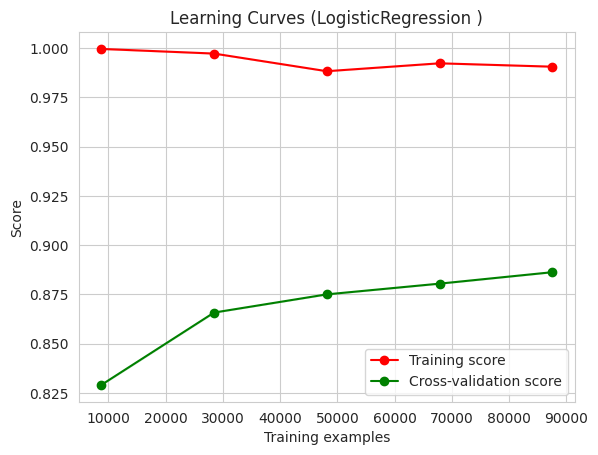

TEST SET REPORT (BINARY-CLASS) =================================


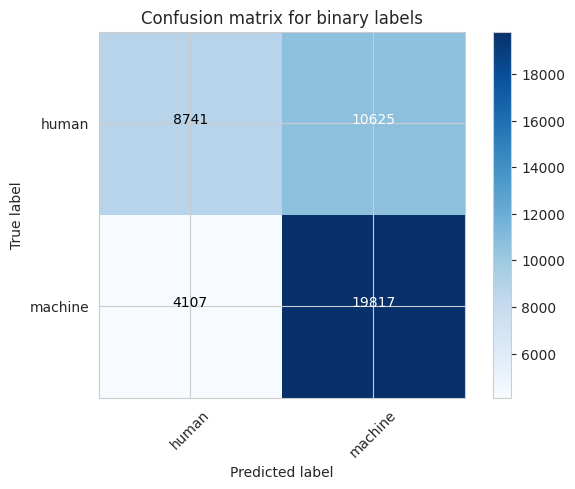

              precision    recall  f1-score   support

       human     0.6803    0.4514    0.5427     19366
     machine     0.6510    0.8283    0.7290     23924

    accuracy                         0.6597     43290
   macro avg     0.6657    0.6398    0.6359     43290
weighted avg     0.6641    0.6597    0.6457     43290

Test Accuracy: 0.6597
Test macro-F1: 0.6359



CPU times: user 20min 22s, sys: 4.65 s, total: 20min 27s
Wall time: 5min 56s


In [9]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-1",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 1))
    },
    {
        "name": "tf-idf-1",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 1))
    },
]

for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        model: MLClassifier = MLClassifier(estimator=LogisticRegression(),
                                           vectorizer=vectorizer,
                                           optimization_grid=max_ent_grid,
                                           feat_selector=None)

        x_train, y_train, x_val, y_val, x_test, y_test = (x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                                                          x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

        model.train(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)
        # TESTING =================>
        model.predict_with_report(x_test=x_test, y_true=y_test)

In this case, we achieve a slightly higher performance of **63.59% macro-F1** by using Logistic Regression, unigrams and TF-IDF.

Let's see what happens if we train the same model but with bigrams.

TRAINING condition: 'tf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Training feature extractor on x_train...
Feature extractor trained!

Training label encoder on y_train
Label encoder trained!

Training classifier with predefined split given by the validation set
Fitting 1 folds for each of 22 candidates, totalling 22 fits
[CV

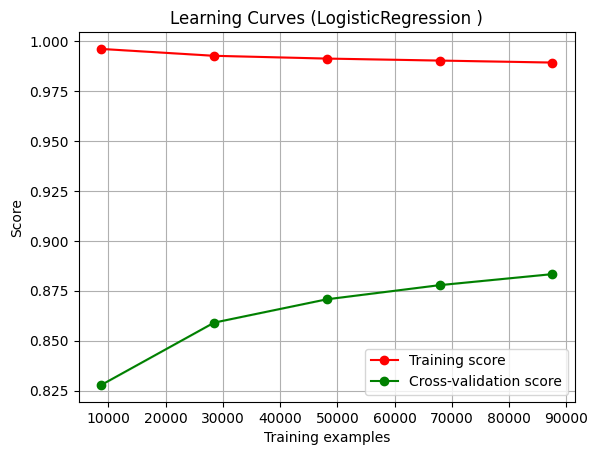

TEST SET REPORT (BINARY-CLASS) =================================


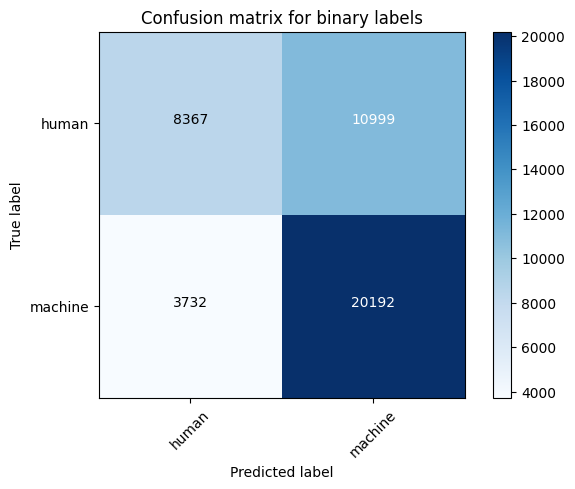

              precision    recall  f1-score   support

       human     0.6915    0.4320    0.5318     19366
     machine     0.6474    0.8440    0.7327     23924

    accuracy                         0.6597     43290
   macro avg     0.6695    0.6380    0.6323     43290
weighted avg     0.6671    0.6597    0.6429     43290

Test Accuracy: 0.6597
Test macro-F1: 0.6323



TRAINING condition: 'tf-idf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'norm': 'l2', 'preproce

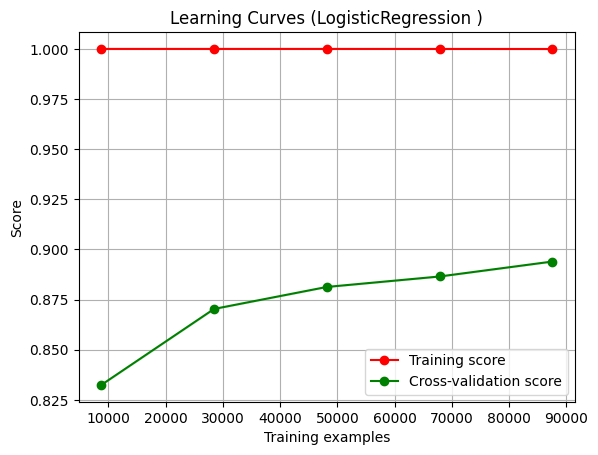

TEST SET REPORT (BINARY-CLASS) =================================


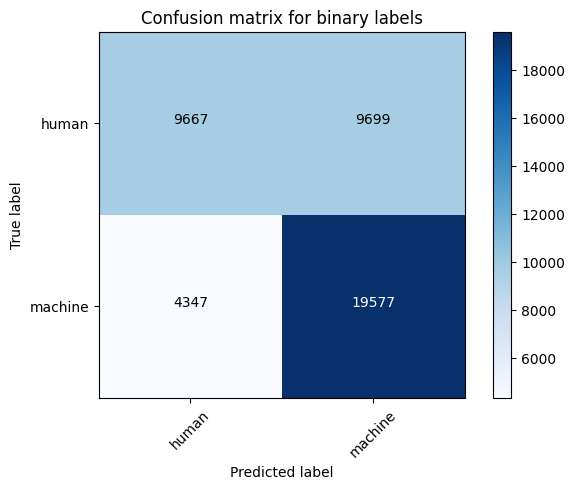

              precision    recall  f1-score   support

       human     0.6898    0.4992    0.5792     19366
     machine     0.6687    0.8183    0.7360     23924

    accuracy                         0.6755     43290
   macro avg     0.6793    0.6587    0.6576     43290
weighted avg     0.6781    0.6755    0.6658     43290

Test Accuracy: 0.6755
Test macro-F1: 0.6576



CPU times: user 35min 29s, sys: 45.2 s, total: 36min 14s
Wall time: 19min 6s


In [11]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-2",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 2))
    },
    {
        "name": "tf-idf-2",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 2))
    }
]

for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        model: MLClassifier = MLClassifier(estimator=LogisticRegression(),
                                           vectorizer=vectorizer,
                                           optimization_grid=max_ent_grid,
                                           feat_selector=None)

        x_train, y_train, x_val, y_val, x_test, y_test = (x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                                                          x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

        model.train(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)
        # TESTING =================>
        model.predict_with_report(x_test=x_test, y_true=y_test)

Using bigrams and TF-IDF, we achieve a performance of **65.76% macro-F1** with Logistic Regression, surpassing our previous result.

We can still observe from the loss functions that the model still seems to be overfitting, as we observe a perfect score on the train set.

💔 _I couldn't run LR with trigrams, as my computer, even with 64GBs of RAM, would crash (vocabulary size must be too big in this configuration).'_ I will done one final try but using feature selection, in order to see if we can reduce the vocabulary size by doing this and train using trigrams.

TRAINING condition: 'tf-3' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 3), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Feature selector class used: <class 'sklearn.feature_selection._univariate_selection.SelectKBest'> with config: {'k': 30000, 'score_func': <function chi2 at 0x7fbdcfec37e0>} ===
Training feature extractor on x_train...
Feature extractor trained!

Training featu

/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.876 total time=  13.5s
[CV 1/1] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.864 total time=   1.3s
[CV 1/1] END C=1, max_iter=500, penalty=l1, solver=liblinear;, score=0.873 total time=  17.9s
[CV 1/1] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.868 total time=  21.8s
[CV 1/1] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.853 total time=  26.8s
[CV 1/1] END C=0.001, max_iter=500, penalty=l1, solver=liblinear;, score=0.562 total time=   1.1s
[CV 1/1] END C=0.1, max_iter=500, penalty=l2, solver=liblinear;, score=0.877 total time=  26.0s
[CV 1/1] END C=0.01, max_iter=500, penalty=l1, solver=liblinear;, score=0.776 total time=   2.8s
[CV 1/1] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.876 total time=  37.8s
[CV 1/1] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.877 total time=   5.6s
[CV 1/1] END C=10, max_iter=500, penalty=l2, solver=liblinear;

/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1] END C=0.01, max_iter=500, penalty=l2, solver=liblinear;, score=0.864 total time=  12.3s
[CV 1/1] END C=1000, max_iter=500, penalty=l2, solver=liblinear;, score=0.866 total time= 1.9min


/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.832 total time=   0.6s
[CV 1/1] END C=0.1, max_iter=500, penalty=l1, solver=liblinear;, score=0.854 total time=   4.3s
[CV 1/1] END C=10, max_iter=500, penalty=l1, solver=liblinear;, score=0.861 total time= 2.3min
Best estimator is: LogisticRegression(C=0.1, max_iter=500, solver='liblinear')
Model trained correctly

Plotting val-scores for each grid configuration
{'mean_fit_time': array([ 11.05962253,   0.5702517 ,   1.32449698,   5.61864471,
        13.44828439,  21.74374604,  10.67650294,  26.81175923,
         1.07690907,   6.09120274,   2.79888558,  12.25079226,
         4.28615475,  26.03229213,  17.93096018,  37.77078104,
       137.39557958,  87.22873116, 429.55197668, 156.11753297,
       395.11153054, 111.01916409]), 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.]), 'mean_score_time': array([0.01914787, 0.00762343, 0.02166533, 0.01613188,

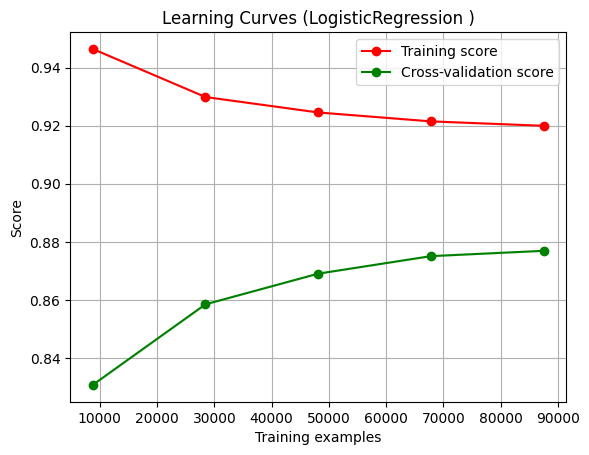

TEST SET REPORT (BINARY-CLASS) =================================


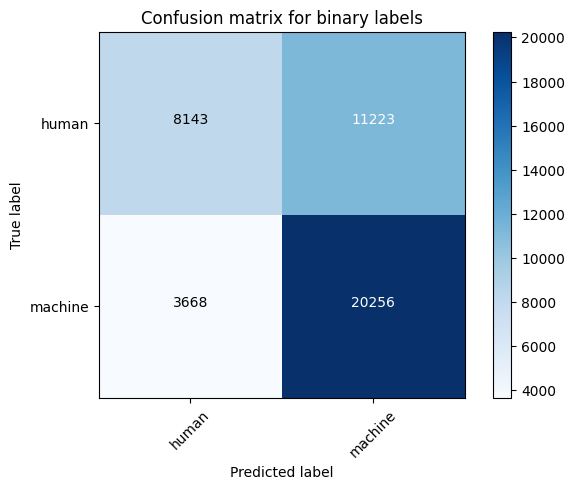

              precision    recall  f1-score   support

       human     0.6894    0.4205    0.5224     19366
     machine     0.6435    0.8467    0.7312     23924

    accuracy                         0.6560     43290
   macro avg     0.6665    0.6336    0.6268     43290
weighted avg     0.6640    0.6560    0.6378     43290

Test Accuracy: 0.656
Test macro-F1: 0.6268



TRAINING condition: 'tf-idf-3' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 3), 'norm': 'l2', 'preproces

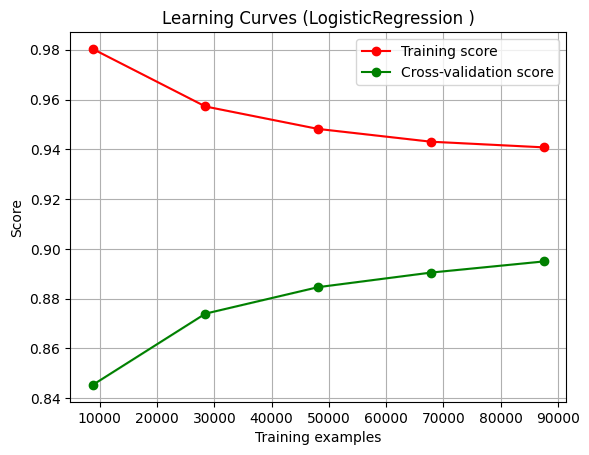

TEST SET REPORT (BINARY-CLASS) =================================


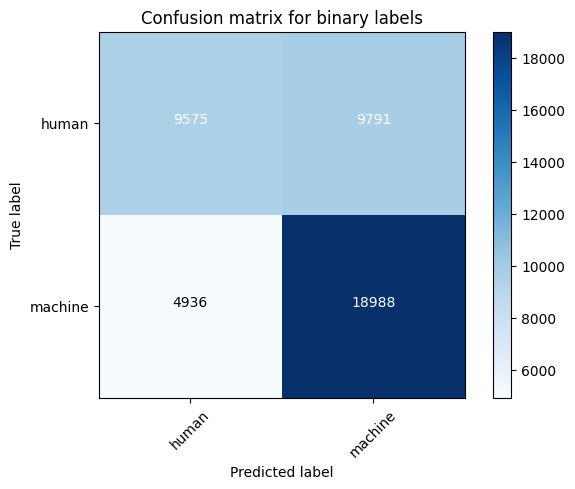

              precision    recall  f1-score   support

       human     0.6598    0.4944    0.5653     19366
     machine     0.6598    0.7937    0.7206     23924

    accuracy                         0.6598     43290
   macro avg     0.6598    0.6441    0.6429     43290
weighted avg     0.6598    0.6598    0.6511     43290

Test Accuracy: 0.6598
Test macro-F1: 0.6429



CPU times: user 9min 2s, sys: 12.1 s, total: 9min 14s
Wall time: 11min 23s


In [28]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-3",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 3))
    },
    {
        "name": "tf-idf-3",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 3))
    }
]

for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        for feature_selector in [SelectKBest(chi2, k=30000)]:
            feature_selector_params: dict = None if feature_selector is None else feature_selector.get_params()
            print(f"Feature selector class used: {type(feature_selector)} with config: {feature_selector_params} ===")
            model: MLClassifier = MLClassifier(estimator=LogisticRegression(),
                                               vectorizer=vectorizer,
                                               optimization_grid=max_ent_grid,
                                               feat_selector=feature_selector)

        x_train, y_train, x_val, y_val, x_test, y_test = (x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                                                          x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

        model.train(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)
        # TESTING =================>
        model.predict_with_report(x_test=x_test, y_true=y_test)

We can check that using trigrams and feature selection doesn't improve the previous results.

## Support Vector Machines (SVMs)

[Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html) (SVMs) work well for text classification problems and often produce more accurate models. Using sklearn, we will implement an SVM classifier to see if we can surpass the results obtained with Naïve Bayes.

According to the scikit-learn documentation, there is a wide range of parameters we could explore and optimize. Generally, the most important ones to consider are `C`, `gamma` and `kernel`.

Based on general information I found, I would highlight the following points:

- The kernel can be thought of as a type of similarity function:
  - RBF is the most commonly used SVM kernel and is, in fact, the default in sklearn. RBF stands for "radial basis function," a type of function used to approximate other functions in the literature. The mathematics behind it is complex, but essentially, it results in a kernel capable of creating the most complex decision boundaries among those available in sklearn.
  - Computing an RBF kernel is very costly, and it becomes computationally more complex as the number of samples exceeds a few tens of thousands (which is our case now).
- `C` and `gamma` are regularization hyperparameters used to prevent overfitting in these types of models:
  - `gamma` is a multiplier applied as a regularization parameter in the kernel computation. Intuitively, the higher the `gamma`, the more precise the fit will be (increasing the risk of overfitting).
  - `C` is a fixed cost added each time similarity is calculated (essentially an L1 norm). The higher the value of `C`, the better the fit achieved (similar to `gamma`).

In [11]:
# We can see the parameters and their defaults fairly easily with the following command
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [13]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-1",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 1))
    },
    {
        "name": "tf-idf-1",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 1))
    },
]

svm_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear', 'rbf']}
for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        model: MLClassifier = MLClassifier(estimator=SVC(),
                                           vectorizer=vectorizer,
                                           optimization_grid=svm_grid,
                                           feat_selector=None)

        x_train, y_train, x_val, y_val, x_test, y_test = (x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                                                          x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

        model.train(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)
        # TESTING =================>
        model.predict_with_report(x_test=x_test, y_true=y_test)

TRAINING condition: 'tf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Training feature extractor on x_train...
Feature extractor trained!

Training label encoder on y_train
Label encoder trained!

Training classifier with predefined split given by the validation set
Fitting 1 folds for each of 25 candidates, totalling 25 fits


KeyboardInterrupt: 

I decided to stop this training, because even after 10 hours of it, it didn't even finish.

I will try to simplify a bit the grid search, use [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) and try to train with a percentage of the train set for hyperparameter tuning, and then choose that configuration and try to train with the rest.

The other option is to limit the vocabulary size by using a feature selection function, like `ChiSquared`.

TRAINING condition: 'tf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Training feature extractor on x_train...
Feature extractor trained!

Training label encoder on y_train
Label encoder trained!

Training classifier with predefined split given by the validation set
Fitting 1 folds for each of 5 candidates, totalling 5 fits
Best 

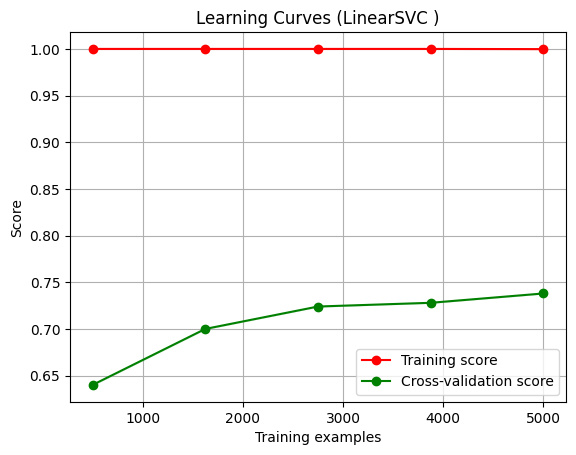

TEST SET REPORT (BINARY-CLASS) =================================


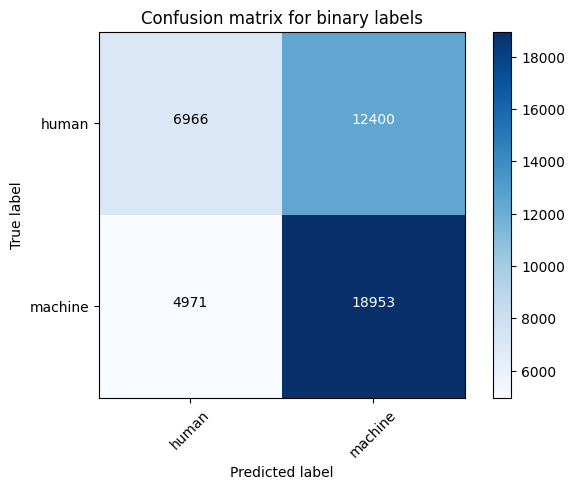

              precision    recall  f1-score   support

       human     0.5836    0.3597    0.4451     19366
     machine     0.6045    0.7922    0.6857     23924

    accuracy                         0.5987     43290
   macro avg     0.5940    0.5760    0.5654     43290
weighted avg     0.5951    0.5987    0.5781     43290

Test Accuracy: 0.5987
Test macro-F1: 0.5654



TRAINING condition: 'tf-idf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preproce

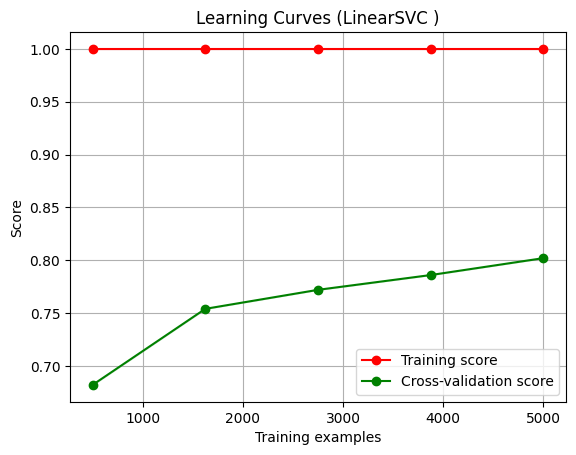

TEST SET REPORT (BINARY-CLASS) =================================


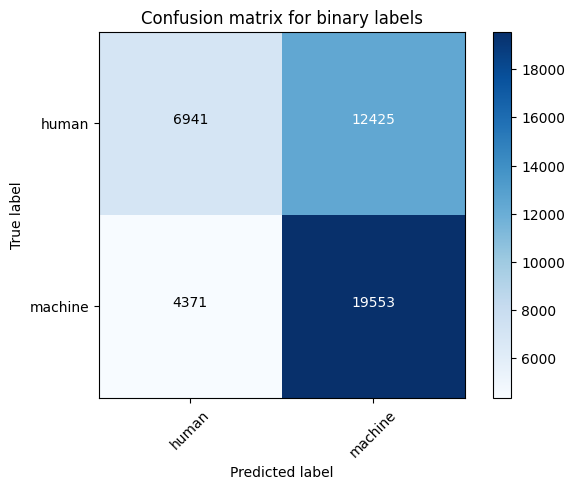

              precision    recall  f1-score   support

       human     0.6136    0.3584    0.4525     19366
     machine     0.6115    0.8173    0.6995     23924

    accuracy                         0.6120     43290
   macro avg     0.6125    0.5879    0.5760     43290
weighted avg     0.6124    0.6120    0.5890     43290

Test Accuracy: 0.612
Test macro-F1: 0.576



CPU times: user 13.6 s, sys: 1.81 s, total: 15.4 s
Wall time: 16.2 s


In [16]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-1",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 1))
    },
    {
        "name": "tf-idf-1",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 1))
    },
]

svm_grid = {'C': [0.1, 1, 10, 100, 1000]}
for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        model: MLClassifier = MLClassifier(estimator=LinearSVC(),
                                           vectorizer=vectorizer,
                                           optimization_grid=svm_grid,
                                           feat_selector=None)

        x_train, y_train, x_val, y_val, x_test, y_test = (x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                                                          x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

        TRAIN_TOP_TO_GET: int = 5000
        VAL_TOP_TO_GET: int = 500

        model.train(x_train=x_train[:TRAIN_TOP_TO_GET],
                    y_train=y_train[:TRAIN_TOP_TO_GET],
                    x_val=x_val[:VAL_TOP_TO_GET],
                    y_val=y_val[:VAL_TOP_TO_GET])
        # TESTING =================>
        model.predict_with_report(x_test=x_test, y_true=y_test)

Using `LinearSVC` completely simplified our task, now we can train the model very fast. Let's repeat but with all of the training data to see how it performs.

TRAINING condition: 'tf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Training feature extractor on x_train...
Feature extractor trained!

Training label encoder on y_train
Label encoder trained!

Training classifier with predefined split given by the validation set
Fitting 1 folds for each of 5 candidates, totalling 5 fits


/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda

Best estimator is: LinearSVC(C=0.1)
Model trained correctly

Plotting val-scores for each grid configuration
{'mean_fit_time': array([50.55695653, 38.88007951, 44.8691175 , 49.16759539, 51.06791449]), 'std_fit_time': array([0., 0., 0., 0., 0.]), 'mean_score_time': array([0.01375175, 0.01930571, 0.03603935, 0.03093529, 0.01162434]), 'std_score_time': array([0., 0., 0., 0., 0.]), 'param_C': masked_array(data=[0.1, 1.0, 10.0, 100.0, 1000.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.86379011, 0.84459274, 0.83028613, 0.82740653, 0.82630953]), 'mean_test_score': array([0.86379011, 0.84459274, 0.83028613, 0.82740653, 0.82630953]), 'std_test_score': array([0., 0., 0., 0., 0.]), 'rank_test_score': array([1, 2, 3, 4, 5], dtype=int32)}
Accuracy: 0.864 (+/-0.000) for params: {'C': 0.1} 

Accuracy: 0.845 (+/-0.000) for params: {'C': 1} 

Accuracy: 0.830 (+/-0.0

/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


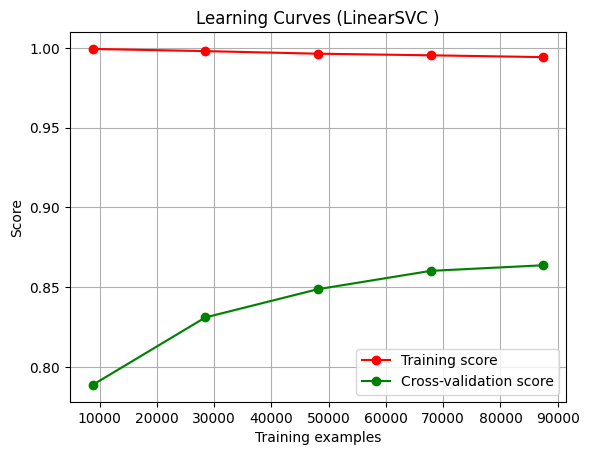

TEST SET REPORT (BINARY-CLASS) =================================


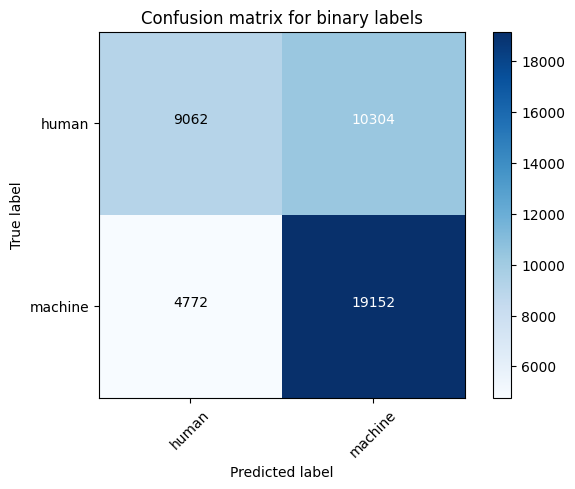

              precision    recall  f1-score   support

       human     0.6551    0.4679    0.5459     19366
     machine     0.6502    0.8005    0.7176     23924

    accuracy                         0.6517     43290
   macro avg     0.6526    0.6342    0.6317     43290
weighted avg     0.6524    0.6517    0.6408     43290

Test Accuracy: 0.6517
Test macro-F1: 0.6317



TRAINING condition: 'tf-idf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preproce

/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best estimator is: LinearSVC(C=1)
Model trained correctly

Plotting val-scores for each grid configuration
{'mean_fit_time': array([ 1.10876322,  3.22618628, 25.66745186, 46.62058306, 42.37452626]), 'std_fit_time': array([0., 0., 0., 0., 0.]), 'mean_score_time': array([0.01041484, 0.01871467, 0.01709628, 0.01064229, 0.01153827]), 'std_score_time': array([0., 0., 0., 0., 0.]), 'param_C': masked_array(data=[0.1, 1.0, 10.0, 100.0, 1000.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.87832526, 0.88668983, 0.87430295, 0.86497852, 0.86077338]), 'mean_test_score': array([0.87832526, 0.88668983, 0.87430295, 0.86497852, 0.86077338]), 'std_test_score': array([0., 0., 0., 0., 0.]), 'rank_test_score': array([2, 1, 3, 4, 5], dtype=int32)}
Accuracy: 0.887 (+/-0.000) for params: {'C': 1} 

Accuracy: 0.878 (+/-0.000) for params: {'C': 0.1} 

Accuracy: 0.874 (+/-0.000

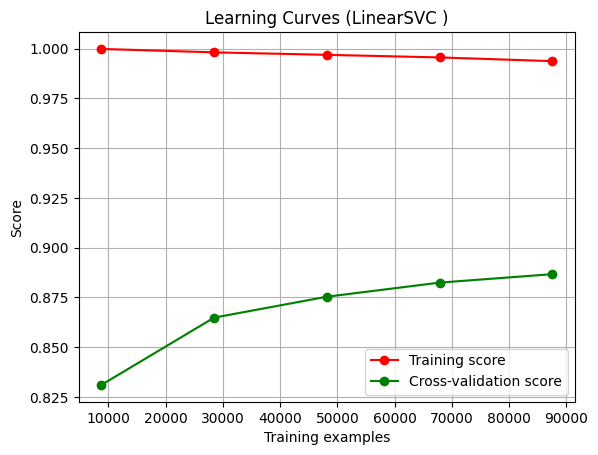

TEST SET REPORT (BINARY-CLASS) =================================


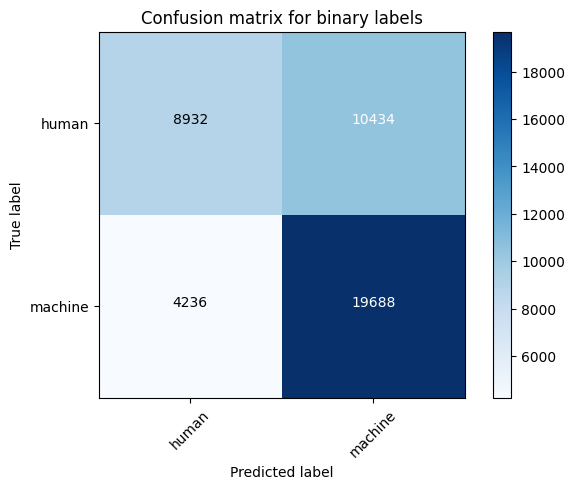

              precision    recall  f1-score   support

       human     0.6783    0.4612    0.5491     19366
     machine     0.6536    0.8229    0.7286     23924

    accuracy                         0.6611     43290
   macro avg     0.6660    0.6421    0.6388     43290
weighted avg     0.6647    0.6611    0.6483     43290

Test Accuracy: 0.6611
Test macro-F1: 0.6388



TRAINING condition: 'tf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'preprocessor': None, 'stop_w

/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1] END .............................C=0.1;, score=0.878 total time=   1.1s
[CV 1/1] END ...............................C=1;, score=0.887 total time=   3.2s
[CV 1/1] END ..............................C=10;, score=0.874 total time=  25.7s
[CV 1/1] END ............................C=1000;, score=0.861 total time=  42.4s
[CV 1/1] END .............................C=100;, score=0.865 total time=  46.6s


/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best estimator is: LinearSVC(C=0.1)
Model trained correctly

Plotting val-scores for each grid configuration
{'mean_fit_time': array([ 87.44832468, 118.0193727 , 152.5948627 , 157.61942625,
       173.91239119]), 'std_fit_time': array([0., 0., 0., 0., 0.]), 'mean_score_time': array([0.06267571, 0.04397249, 0.03859997, 0.0515728 , 0.037045  ]), 'std_score_time': array([0., 0., 0., 0., 0.]), 'param_C': masked_array(data=[0.1, 1.0, 10.0, 100.0, 1000.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.86982357, 0.86246458, 0.86095621, 0.86081909, 0.85999634]), 'mean_test_score': array([0.86982357, 0.86246458, 0.86095621, 0.86081909, 0.85999634]), 'std_test_score': array([0., 0., 0., 0., 0.]), 'rank_test_score': array([1, 2, 3, 4, 5], dtype=int32)}
Accuracy: 0.870 (+/-0.000) for params: {'C': 0.1} 

Accuracy: 0.862 (+/-0.000) for params: {'C': 1} 

Accuracy: 0

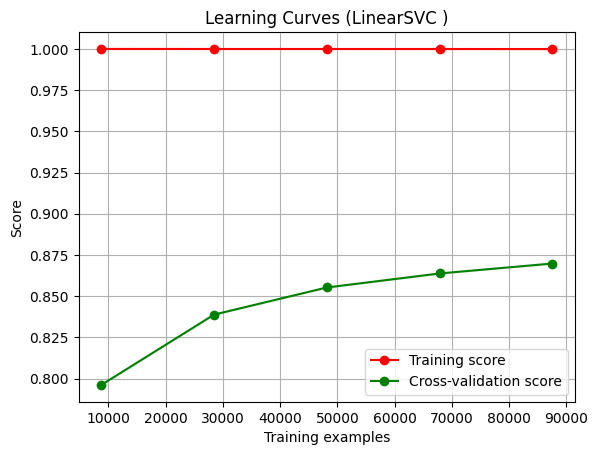

TEST SET REPORT (BINARY-CLASS) =================================


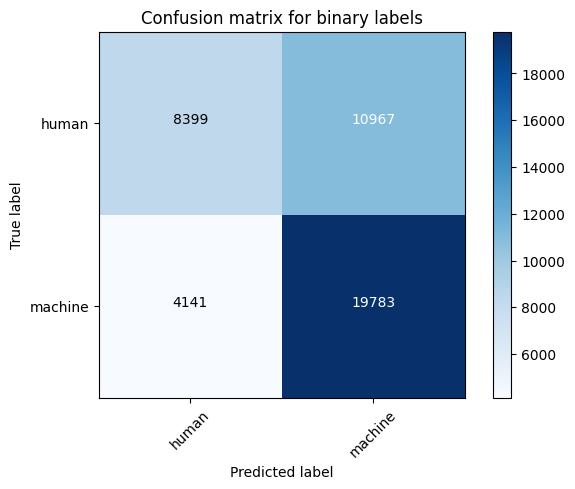

              precision    recall  f1-score   support

       human     0.6698    0.4337    0.5265     19366
     machine     0.6433    0.8269    0.7237     23924

    accuracy                         0.6510     43290
   macro avg     0.6566    0.6303    0.6251     43290
weighted avg     0.6552    0.6510    0.6355     43290

Test Accuracy: 0.651
Test macro-F1: 0.6251



TRAINING condition: 'tf-idf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'norm': 'l2', 'preproces

/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best estimator is: LinearSVC(C=10)
Model trained correctly

Plotting val-scores for each grid configuration
{'mean_fit_time': array([  5.51251531,  11.46610594,  74.41700482, 215.10348392,
       190.38405371]), 'std_fit_time': array([0., 0., 0., 0., 0.]), 'mean_score_time': array([0.053725  , 0.05597281, 0.03173113, 0.02354622, 0.02853417]), 'std_score_time': array([0., 0., 0., 0., 0.]), 'param_C': masked_array(data=[0.1, 1.0, 10.0, 100.0, 1000.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.87201755, 0.89295182, 0.89669988, 0.89669988, 0.89605997]), 'mean_test_score': array([0.87201755, 0.89295182, 0.89669988, 0.89669988, 0.89605997]), 'std_test_score': array([0., 0., 0., 0., 0.]), 'rank_test_score': array([5, 4, 1, 1, 3], dtype=int32)}
Accuracy: 0.897 (+/-0.000) for params: {'C': 10} 

Accuracy: 0.897 (+/-0.000) for params: {'C': 100} 

Accuracy: 0

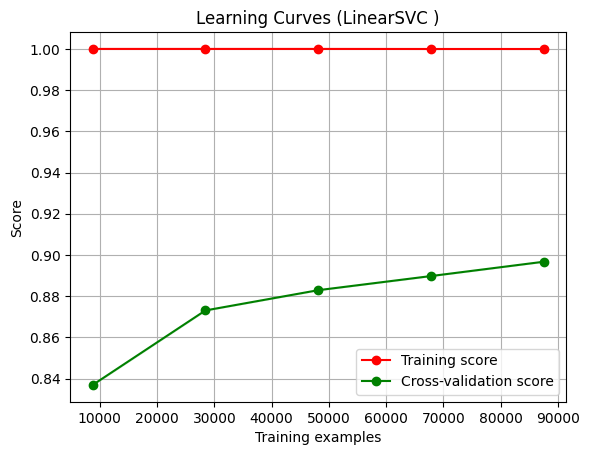

[CV 1/1] END ..............................C=10;, score=0.897 total time= 1.2min
TEST SET REPORT (BINARY-CLASS) =================================


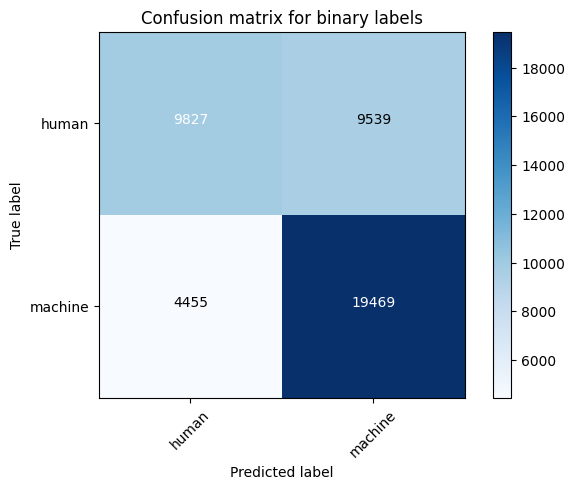

              precision    recall  f1-score   support

       human     0.6881    0.5074    0.5841     19366
     machine     0.6712    0.8138    0.7356     23924

    accuracy                         0.6767     43290
   macro avg     0.6796    0.6606    0.6599     43290
weighted avg     0.6787    0.6767    0.6678     43290

Test Accuracy: 0.6767
Test macro-F1: 0.6599



CPU times: user 10min 15s, sys: 7.55 s, total: 10min 22s
Wall time: 18min 27s


In [18]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-1",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 1))
    },
    {
        "name": "tf-idf-1",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 1))
    },
    {
        "name": "tf-2",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 2))
    },
    {
        "name": "tf-idf-2",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 2))
    }
]

svm_grid = {'C': [0.1, 1, 10, 100, 1000]}
for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        model: MLClassifier = MLClassifier(estimator=LinearSVC(),
                                           vectorizer=vectorizer,
                                           optimization_grid=svm_grid,
                                           feat_selector=None)

        x_train, y_train, x_val, y_val, x_test, y_test = (x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                                                          x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

        model.train(x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val)
        # TESTING =================>
        model.predict_with_report(x_test=x_test, y_true=y_test)



In some cases, we observe this warning: `ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.`. I'll repeat the previous best result but increasing the number of iterations to see how it performs. By default, `max_iter=1000`

TRAINING condition: 'tf-idf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': None, 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}
Training feature extractor on x_train...
Feature extractor trained!

Training label encoder on y_train
Label encoder trained!

Training classifier with predefined split given by the

/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best estimator is: LinearSVC(C=10, max_iter=2500)
Model trained correctly

Plotting val-scores for each grid configuration
{'mean_fit_time': array([  4.66097498,  11.1289885 , 103.47610927, 548.54411221,
       629.09660673]), 'std_fit_time': array([0., 0., 0., 0., 0.]), 'mean_score_time': array([0.05093265, 0.0347352 , 0.04522657, 0.03074908, 0.03863263]), 'std_score_time': array([0., 0., 0., 0., 0.]), 'param_C': masked_array(data=[0.1, 1.0, 10.0, 100.0, 1000.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20), 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.87201755, 0.89295182, 0.89669988, 0.89647134, 0.89514581]), 'mean_test_score': array([0.87201755, 0.89295182, 0.89669988, 0.89647134, 0.89514581]), 'std_test_score': array([0., 0., 0., 0., 0.]), 'rank_test_score': array([5, 4, 1, 2, 3], dtype=int32)}
Accuracy: 0.897 (+/-0.000) for params: {'C': 10} 

Accuracy: 0.896 (+/-0.000) for params: {'C': 100

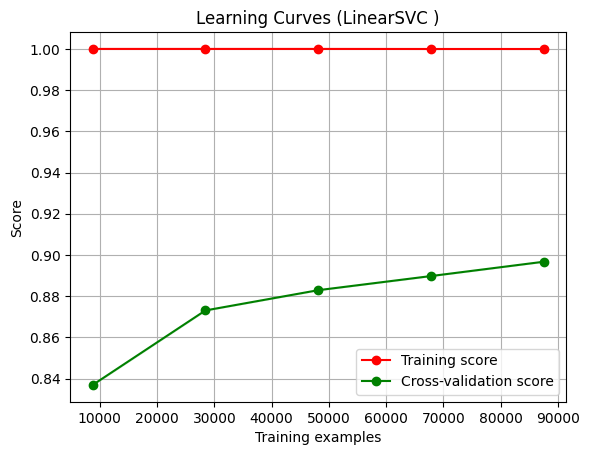

[CV 1/1] END .............................C=100;, score=0.896 total time= 9.1min
TEST SET REPORT (BINARY-CLASS) =================================


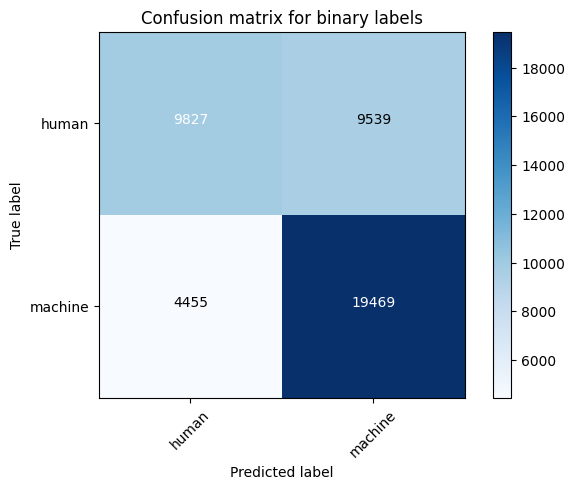

              precision    recall  f1-score   support

       human     0.6881    0.5074    0.5841     19366
     machine     0.6712    0.8138    0.7356     23924

    accuracy                         0.6767     43290
   macro avg     0.6796    0.6606    0.6599     43290
weighted avg     0.6787    0.6767    0.6678     43290

Test Accuracy: 0.6767
Test macro-F1: 0.6599



CPU times: user 4min 40s, sys: 5.63 s, total: 4min 46s
Wall time: 15min 13s


In [19]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-idf-2",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 2))
    }
]

svm_grid = {'C': [0.1, 1, 10, 100, 1000]}
for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        model: MLClassifier = MLClassifier(estimator=LinearSVC(max_iter=2500),
                                           vectorizer=vectorizer,
                                           optimization_grid=svm_grid,
                                           feat_selector=None)

        x_train, y_train, x_val, y_val, x_test, y_test = (x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                                                          x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

        model.train(x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val)
        # TESTING =================>
        model.predict_with_report(x_test=x_test, y_true=y_test)

We get the same performance as before, and still the same warning on convergence.

Let's repeat the previous result, but using [feature selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html), to see what results we get. If it can train relatively fast, we can use trigrams and see how they perform.

TRAINING condition: 'tf-idf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': None, 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}
Feature selector class used: <class 'sklearn.feature_selection._univariate_selection.SelectKBest'> with config: {'k': 10000, 'score_func': <function chi2 at 0x7fbdcfec37e0>} ===
Tra

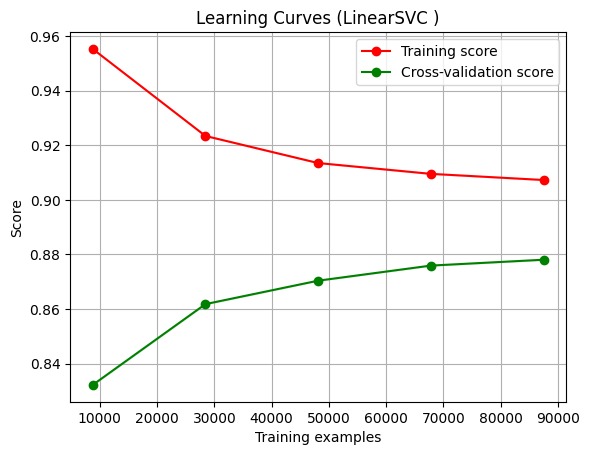

TEST SET REPORT (BINARY-CLASS) =================================


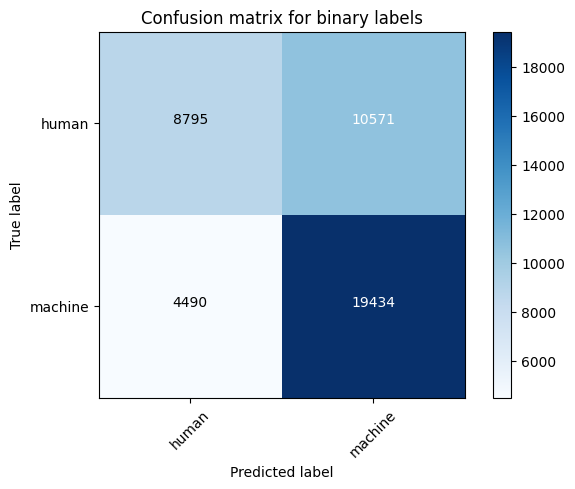

              precision    recall  f1-score   support

       human     0.6620    0.4541    0.5387     19366
     machine     0.6477    0.8123    0.7207     23924

    accuracy                         0.6521     43290
   macro avg     0.6549    0.6332    0.6297     43290
weighted avg     0.6541    0.6521    0.6393     43290

Test Accuracy: 0.6521
Test macro-F1: 0.6297



TRAINING condition: 'tf-idf-3' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 3), 'norm': 'l2', 'preproce

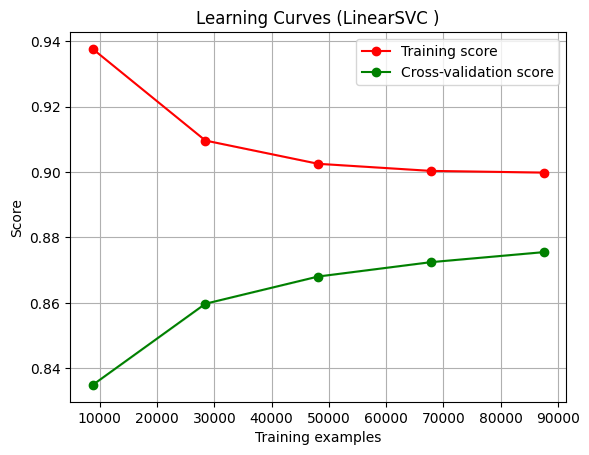

TEST SET REPORT (BINARY-CLASS) =================================


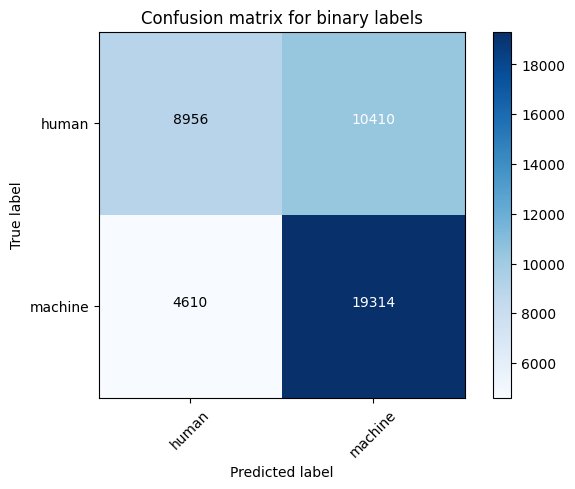

              precision    recall  f1-score   support

       human     0.6602    0.4625    0.5439     19366
     machine     0.6498    0.8073    0.7200     23924

    accuracy                         0.6530     43290
   macro avg     0.6550    0.6349    0.6320     43290
weighted avg     0.6544    0.6530    0.6412     43290

Test Accuracy: 0.653
Test macro-F1: 0.632





In [20]:
train_conditions: list[dict] = [
    {
        "name": "tf-idf-2",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 2))
    },
    {
        "name": "tf-idf-3",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 3))
    },
]

svm_grid = {'C': [0.1, 1, 10, 100, 1000]}
for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        for feature_selector in [SelectKBest(chi2, k=10000)]:
            feature_selector_params: dict = None if feature_selector is None else feature_selector.get_params()
            print(f"Feature selector class used: {type(feature_selector)} with config: {feature_selector_params} ===")
            model: MLClassifier = MLClassifier(estimator=LinearSVC(max_iter=1000),
                                               vectorizer=vectorizer,
                                               optimization_grid=svm_grid,
                                               feat_selector=feature_selector)

            x_train, y_train, x_val, y_val, x_test, y_test = (
            x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
            x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

            model.train(x_train=x_train,
                        y_train=y_train,
                        x_val=x_val,
                        y_val=y_val)
            # TESTING =================>
            model.predict_with_report(x_test=x_test, y_true=y_test)

We were able to train the LinearSVC on trigrams by using feature selection, but it seems that we took it too hard by selecting only 10k features. As we can see, the results are worse than before.

To conclude this section, the best LinearSVC model that we were able to achieve slightly surpasses the Logistic Regression model, with a performance of **65.99% macro-F1**

## Random Forests

We are going to study the behavior of [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifiers.

*A random forest is a meta-estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve predictive accuracy and reduce overfitting. The sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True` (default), otherwise, the entire dataset is used to build each tree.*

### Explorable Parameters

As with `SVC` and `MaxEnt`, there is also a fairly large list of potential parameters to explore. I would say that, for now, this model has the most configurable parameters.

According to [this blog](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) and the scikit-learn documentation, I will focus on the following parameters:

- **`n_estimators`** – the number of trees in the forest.
- **`criterion`** – the function used to measure the quality of a split. Supported criteria are “gini” for Gini impurity, and “log_loss” and “entropy,” both representing Shannon information gain.
- **`max_depth`** – the maximum depth of each tree. If `None`, nodes will be expanded until all leaves are pure or until they contain fewer samples than `min_samples_split`.
- **`min_samples_split`** – the minimum number of samples required to split an internal node.
- **`min_samples_leaf`** – the minimum number of samples required to be at a leaf node.
- **`max_features`** – the number of features to consider when looking for the best split.
- **`bootstrap`** – whether bootstrap samples are used when building trees. If `False`, the entire dataset is used to build each tree.

*One thing I noticed while training this model is that it is quite slow to train, at least compared to others like `MaxEnt`. However, from what I researched, the main limitation of Random Forest is that if the number of trees is very large, the algorithm becomes too slow and ineffective for real-time predictions. In general, it is said to be fast for training but quite slow for inference. To counter this and to test more combinations, I will only test it on top of feature selection and perhaps with fewer parameter combinations than I originally intended.*

In [21]:
# We can see the parameters and their defaults fairly easily with the following command
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Just like with Support Vector Machines, I will use feature selection to accelerate training.

TRAINING condition: 'tf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Feature selector class used: <class 'sklearn.feature_selection._univariate_selection.SelectKBest'> with config: {'k': 10000, 'score_func': <function chi2 at 0x7fbdcfec37e0>} ===
Training feature extractor on x_train...
Feature extractor trained!

Training featu

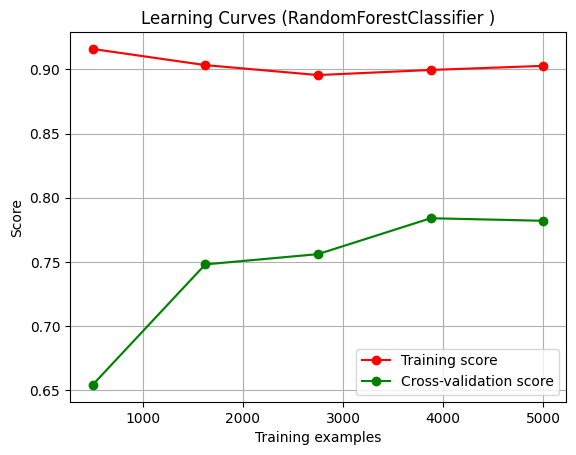

TEST SET REPORT (BINARY-CLASS) =================================


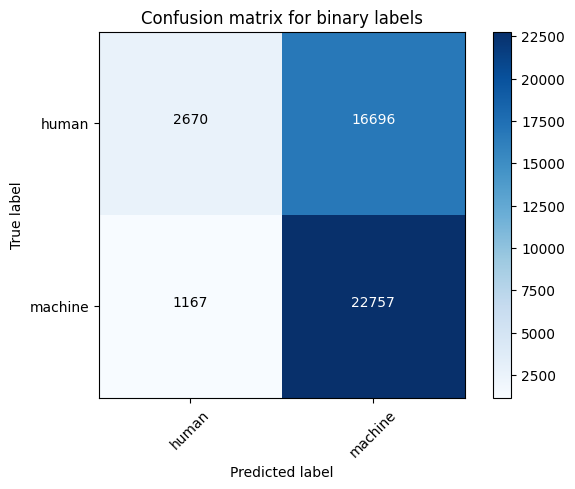

              precision    recall  f1-score   support

       human     0.6959    0.1379    0.2301     19366
     machine     0.5768    0.9512    0.7181     23924

    accuracy                         0.5874     43290
   macro avg     0.6363    0.5445    0.4741     43290
weighted avg     0.6301    0.5874    0.4998     43290

Test Accuracy: 0.5874
Test macro-F1: 0.4741



TRAINING condition: 'tf-idf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preproce

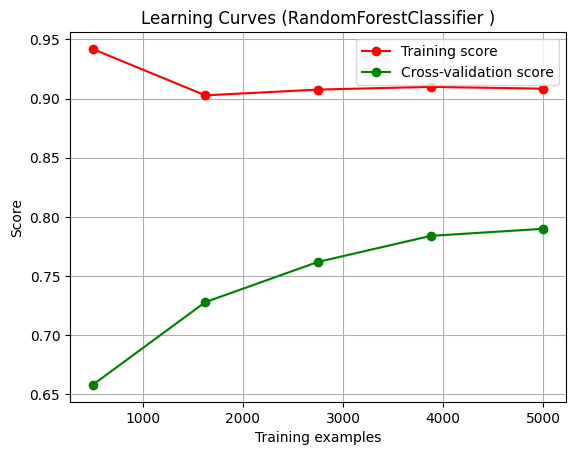

TEST SET REPORT (BINARY-CLASS) =================================


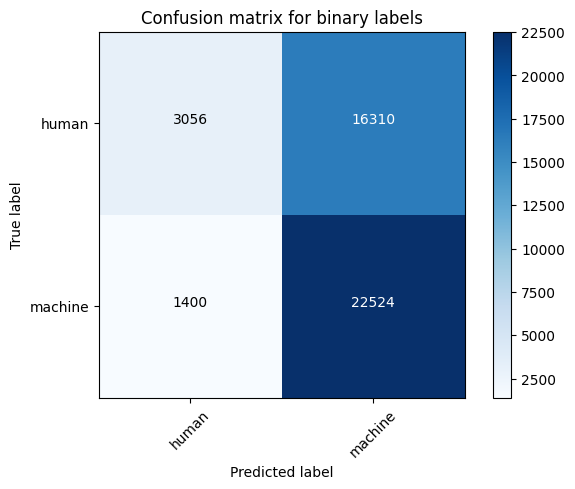

              precision    recall  f1-score   support

       human     0.6858    0.1578    0.2566     19366
     machine     0.5800    0.9415    0.7178     23924

    accuracy                         0.5909     43290
   macro avg     0.6329    0.5496    0.4872     43290
weighted avg     0.6273    0.5909    0.5115     43290

Test Accuracy: 0.5909
Test macro-F1: 0.4872



CPU times: user 2min 6s, sys: 3.89 s, total: 2min 10s
Wall time: 1min 16s


In [23]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-1",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 1))
    },
    {
        "name": "tf-idf-1",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 1))
    },
]

random_forest_grid = {
    "n_estimators": [32, 64, 128, 256],
    # "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [16, 32, 64],
    "min_samples_split": [2, 0.05, 0.1],
    "min_samples_leaf": [1, 0.1, 0.2],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True]
}

for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        for feature_selector in [SelectKBest(chi2, k=10000)]:
            feature_selector_params: dict = None if feature_selector is None else feature_selector.get_params()
            print(f"Feature selector class used: {type(feature_selector)} with config: {feature_selector_params} ===")
            model: MLClassifier = MLClassifier(estimator=RandomForestClassifier(n_jobs=-1, random_state=999),
                                               vectorizer=vectorizer,
                                               optimization_grid=random_forest_grid,
                                               feat_selector=feature_selector,
                                               verbosity=0)

            x_train, y_train, x_val, y_val, x_test, y_test = (
                x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

            SUBSET_TRAIN_SIZE: int = 5000
            SUBSET_VAL_SIZE: int = 500
            model.train(x_train=x_train[:SUBSET_TRAIN_SIZE],
                        y_train=y_train[:SUBSET_TRAIN_SIZE],
                        x_val=x_val[:SUBSET_VAL_SIZE],
                        y_val=y_val[:SUBSET_VAL_SIZE])
            # TESTING =================>
            model.predict_with_report(x_test=x_test, y_true=y_test)

As you noticed, I had to prune some of the exploration params and (and start with unigrams) do a quick test, as it takes a lot of time to train this classifier. Now I will try with the whole dataset.

TRAINING condition: 'tf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Feature selector class used: <class 'sklearn.feature_selection._univariate_selection.SelectKBest'> with config: {'k': 10000, 'score_func': <function chi2 at 0x7fbdcfec37e0>} ===
Training feature extractor on x_train...
Feature extractor trained!

Training featu

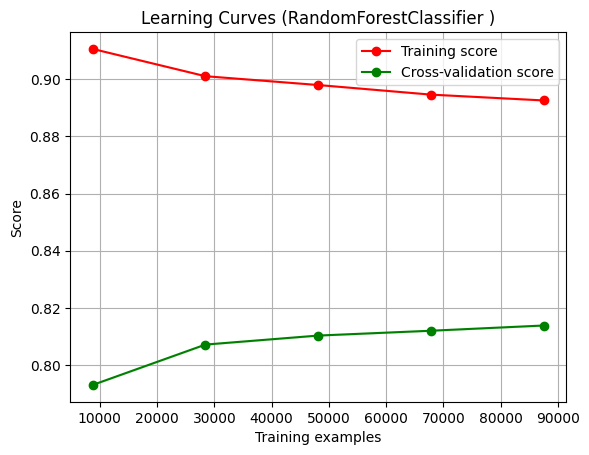

TEST SET REPORT (BINARY-CLASS) =================================


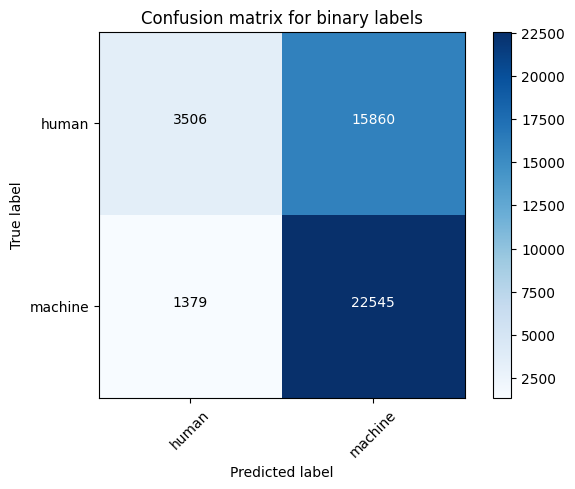

              precision    recall  f1-score   support

       human     0.7177    0.1810    0.2891     19366
     machine     0.5870    0.9424    0.7234     23924

    accuracy                         0.6018     43290
   macro avg     0.6524    0.5617    0.5063     43290
weighted avg     0.6455    0.6018    0.5291     43290

Test Accuracy: 0.6018
Test macro-F1: 0.5063



TRAINING condition: 'tf-idf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preproce

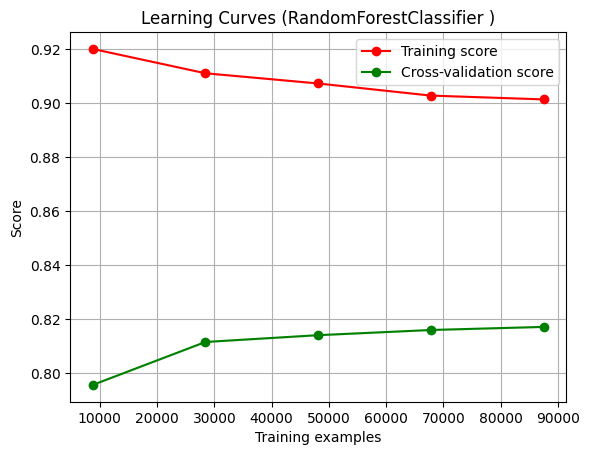

TEST SET REPORT (BINARY-CLASS) =================================


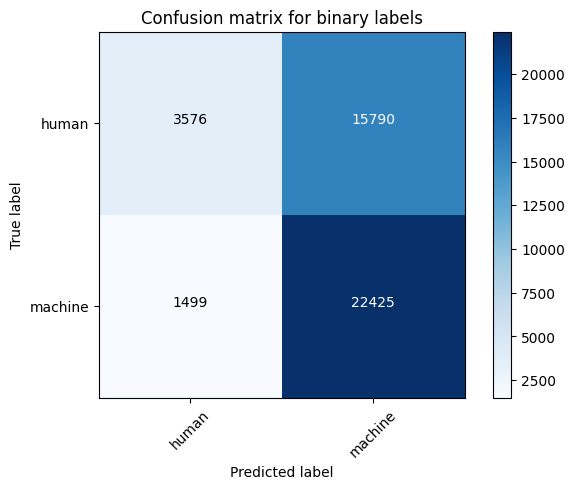

              precision    recall  f1-score   support

       human     0.7046    0.1847    0.2926     19366
     machine     0.5868    0.9373    0.7218     23924

    accuracy                         0.6006     43290
   macro avg     0.6457    0.5610    0.5072     43290
weighted avg     0.6395    0.6006    0.5298     43290

Test Accuracy: 0.6006
Test macro-F1: 0.5072



CPU times: user 1h 5min 26s, sys: 9.1 s, total: 1h 5min 35s
Wall time: 16min 27s


In [24]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-1",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 1))
    },
    {
        "name": "tf-idf-1",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 1))
    },
]

random_forest_grid = {
    "n_estimators": [32, 64, 128, 256],
    # "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [16, 32, 64],
    "min_samples_split": [2, 0.05, 0.1],
    "min_samples_leaf": [1, 0.1, 0.2],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True]
}

for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        for feature_selector in [SelectKBest(chi2, k=10000)]:
            feature_selector_params: dict = None if feature_selector is None else feature_selector.get_params()
            print(f"Feature selector class used: {type(feature_selector)} with config: {feature_selector_params} ===")
            model: MLClassifier = MLClassifier(estimator=RandomForestClassifier(n_jobs=-1, random_state=999),
                                               vectorizer=vectorizer,
                                               optimization_grid=random_forest_grid,
                                               feat_selector=feature_selector,
                                               verbosity=0)

            x_train, y_train, x_val, y_val, x_test, y_test = (
                x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

            model.train(x_train=x_train,
                        y_train=y_train,
                        x_val=x_val,
                        y_val=y_val)
            # TESTING =================>
            model.predict_with_report(x_test=x_test, y_true=y_test)

TRAINING condition: 'tf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Feature selector class used: <class 'sklearn.feature_selection._univariate_selection.SelectKBest'> with config: {'k': 20000, 'score_func': <function chi2 at 0x7fbdcfec37e0>} ===
Training feature extractor on x_train...
Feature extractor trained!

Training featu

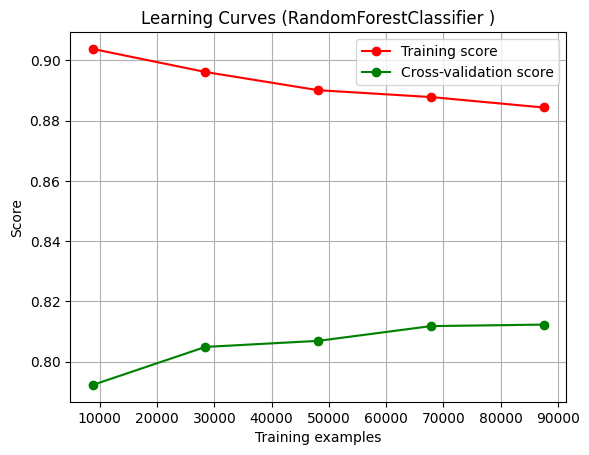

TEST SET REPORT (BINARY-CLASS) =================================


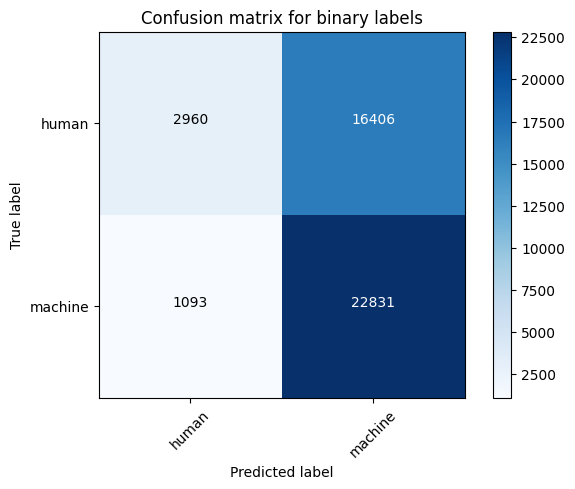

              precision    recall  f1-score   support

       human     0.7303    0.1528    0.2528     19366
     machine     0.5819    0.9543    0.7229     23924

    accuracy                         0.5958     43290
   macro avg     0.6561    0.5536    0.4879     43290
weighted avg     0.6483    0.5958    0.5126     43290

Test Accuracy: 0.5958
Test macro-F1: 0.4879



TRAINING condition: 'tf-idf-2' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 2), 'norm': 'l2', 'preproce

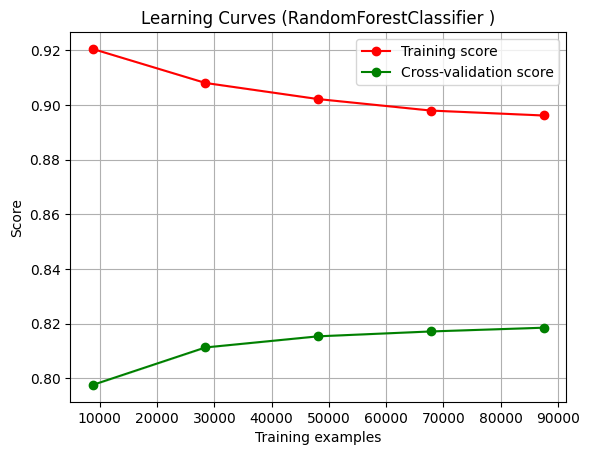

TEST SET REPORT (BINARY-CLASS) =================================


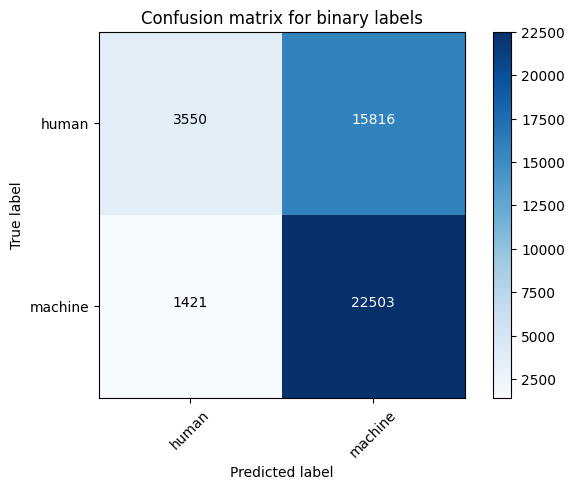

              precision    recall  f1-score   support

       human     0.7141    0.1833    0.2917     19366
     machine     0.5873    0.9406    0.7231     23924

    accuracy                         0.6018     43290
   macro avg     0.6507    0.5620    0.5074     43290
weighted avg     0.6440    0.6018    0.5301     43290

Test Accuracy: 0.6018
Test macro-F1: 0.5074



CPU times: user 1h 4min 38s, sys: 11.8 s, total: 1h 4min 50s
Wall time: 17min 42s


In [25]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-2",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 2))
    },
    {
        "name": "tf-idf-2",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 2))
    },
]

random_forest_grid = {
    "n_estimators": [32, 64, 128, 256],
    # "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [16, 32, 64],
    "min_samples_split": [2, 0.05, 0.1],
    "min_samples_leaf": [1, 0.1, 0.2],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True]
}

for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        for feature_selector in [SelectKBest(chi2, k=20000)]:
            feature_selector_params: dict = None if feature_selector is None else feature_selector.get_params()
            print(f"Feature selector class used: {type(feature_selector)} with config: {feature_selector_params} ===")
            model: MLClassifier = MLClassifier(estimator=RandomForestClassifier(n_jobs=-1, random_state=999),
                                               vectorizer=vectorizer,
                                               optimization_grid=random_forest_grid,
                                               feat_selector=feature_selector,
                                               verbosity=0)

            x_train, y_train, x_val, y_val, x_test, y_test = (
                x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

            model.train(x_train=x_train,
                        y_train=y_train,
                        x_val=x_val,
                        y_val=y_val)
            # TESTING =================>
            model.predict_with_report(x_test=x_test, y_true=y_test)

Results obtained are really bad, around **50.74% of macro-f1**. We can see that it seems to be really hard for the model to distinguish between MGT and human. If we check the confusion matrices, we can see that the model tends to predict `machine` pretty much always.

## XGBoost

Another algorithm that could have good performance on text classification tasks is XGBoost. As we can see in its [documentation page](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html), the model implements the Estimator interface from scikit-learn, which means we should be able to plug and play this model directly with the code we already have.

### Explorable Parameters

After reading [this blog](https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d), I compiled the following list of parameters. Since both models are tree-based, many of these parameters were already covered when we discussed Random Forests.

In XGBoost, there are two main types of hyperparameters: **tree-specific** and **learning task-specific**.

**Tree-specific hyperparameters control the construction and complexity of the decision trees:**
- `max_depth`: Maximum depth of a tree. Deeper trees can capture more complex patterns in the data but may also lead to overfitting.
- `min_child_weight`: Minimum sum of instance weight (Hessian) required in a child. This controls the complexity of the decision tree by preventing the creation of very small leaves.
- `subsample`: Percentage of rows used for each tree’s construction. Reducing this value can help prevent overfitting by training on a smaller subset of the data.
- `colsample_bytree`: Percentage of columns used for each tree’s construction. Reducing this value can help prevent overfitting by training on a subset of the features.

**Learning task-specific hyperparameters control the overall behavior of the model and the learning process:**
- `eta` (also known as learning rate): Step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps.
- `gamma`: Minimum loss reduction required to split a leaf node. Higher values increase regularization.
- `lambda`: L2 regularization term on weights. Higher values increase regularization.
- `alpha`: L1 regularization term on weights. Higher values increase regularization.

As we did with previous algorithms, we will select a subset of these parameters to evaluate the results.

I will start by training on partial data, as I ran out of memory when trying to train on the whole dataset. I want to get it working fine first and then try to increase the number of samples.


TRAINING condition: 'tf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Feature selector class used: <class 'sklearn.feature_selection._univariate_selection.SelectKBest'> with config: {'k': 10000, 'score_func': <function chi2 at 0x76f5ef48c9a0>} ===
Training feature extractor on x_train...
Feature extractor trained!

Training featu

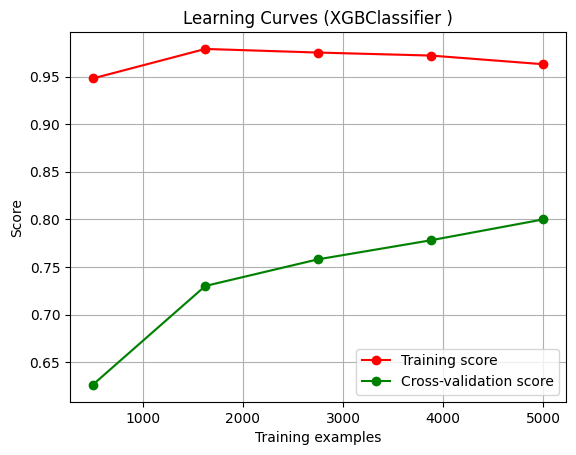

TEST SET REPORT (BINARY-CLASS) =================================


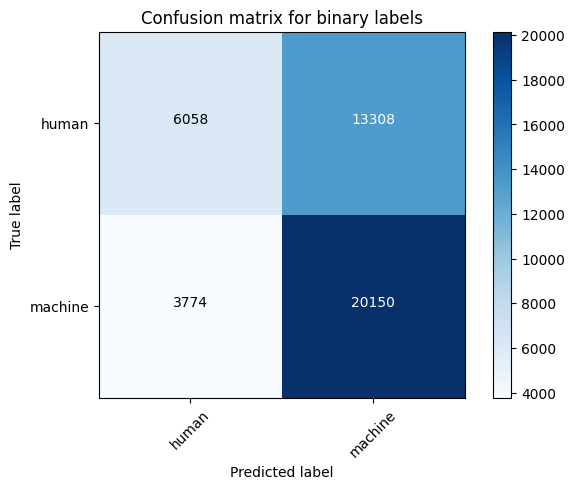

              precision    recall  f1-score   support

       human     0.6162    0.3128    0.4150     19366
     machine     0.6022    0.8423    0.7023     23924

    accuracy                         0.6054     43290
   macro avg     0.6092    0.5775    0.5586     43290
weighted avg     0.6085    0.6054    0.5738     43290

Test Accuracy: 0.6054
Test macro-F1: 0.5586



TRAINING condition: 'tf-idf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preproce

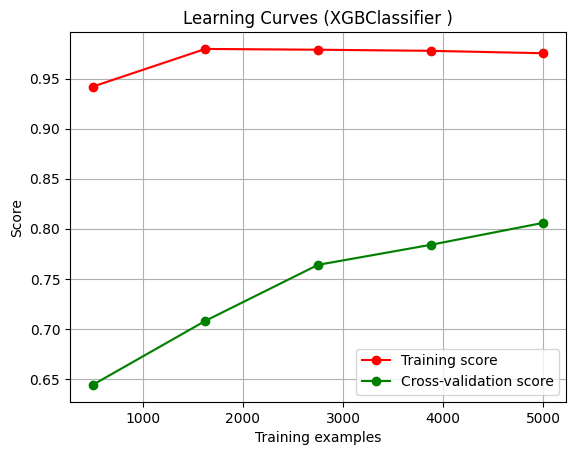

TEST SET REPORT (BINARY-CLASS) =================================


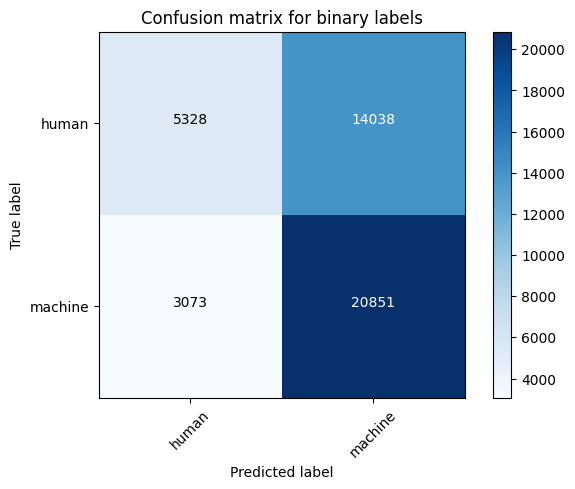

              precision    recall  f1-score   support

       human     0.6342    0.2751    0.3838     19366
     machine     0.5976    0.8716    0.7091     23924

    accuracy                         0.6047     43290
   macro avg     0.6159    0.5733    0.5464     43290
weighted avg     0.6140    0.6047    0.5635     43290

Test Accuracy: 0.6047
Test macro-F1: 0.5464



CPU times: user 27min 16s, sys: 5.29 s, total: 27min 22s
Wall time: 4min 59s


In [19]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-1",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 1))
    },
    {
        "name": "tf-idf-1",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 1))
    },
]

xgboost_grid = {
    # "learning_rate": [0.01, 0.05, 0.1, 0.25, 0.5, 1],
    "learning_rate": [0.1],
    "n_estimators": [32, 64, 128, 256],
    "max_depth": [16, 32, 64]
}

for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        # Initially, no feature selection
        for feature_selector in [SelectKBest(chi2, k=10000)]:
            feature_selector_params: dict = None if feature_selector is None else feature_selector.get_params()
            print(f"Feature selector class used: {type(feature_selector)} with config: {feature_selector_params} ===")
            model: MLClassifier = MLClassifier(estimator=xgb.XGBClassifier(tree_method="hist"),
                                               vectorizer=vectorizer,
                                               optimization_grid=xgboost_grid,
                                               feat_selector=feature_selector,
                                               verbosity=0)

            TRAIN_SUBSET_SAMPLES: int = 5000
            VAL_SUBSET_SAMPLES: int = 500
            x_train, y_train, x_val, y_val, x_test, y_test = (
                x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

            model.train(x_train=x_train[:TRAIN_SUBSET_SAMPLES],
                        y_train=y_train[:TRAIN_SUBSET_SAMPLES],
                        x_val=x_val[:VAL_SUBSET_SAMPLES],
                        y_val=y_val[:VAL_SUBSET_SAMPLES])
            # TESTING =================>
            model.predict_with_report(x_test=x_test, y_true=y_test)

At least we could train the model. Let's try to repeat but with the entire dataset now.

TRAINING condition: 'tf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.CountVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'vocabulary': None}
Feature selector class used: <class 'sklearn.feature_selection._univariate_selection.SelectKBest'> with config: {'k': 10000, 'score_func': <function chi2 at 0x76f5ef48c9a0>} ===
Training feature extractor on x_train...
Feature extractor trained!

Training featu

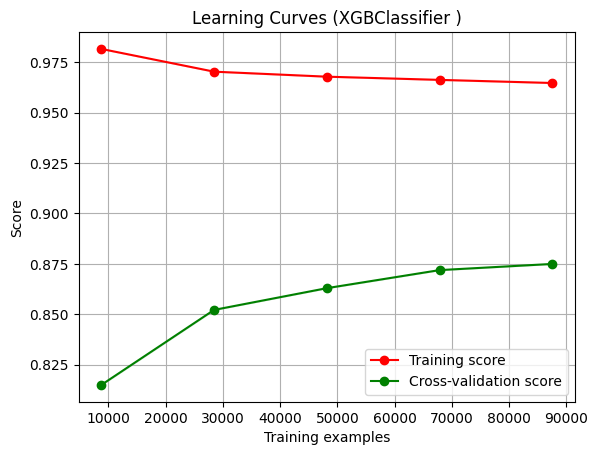

TEST SET REPORT (BINARY-CLASS) =================================


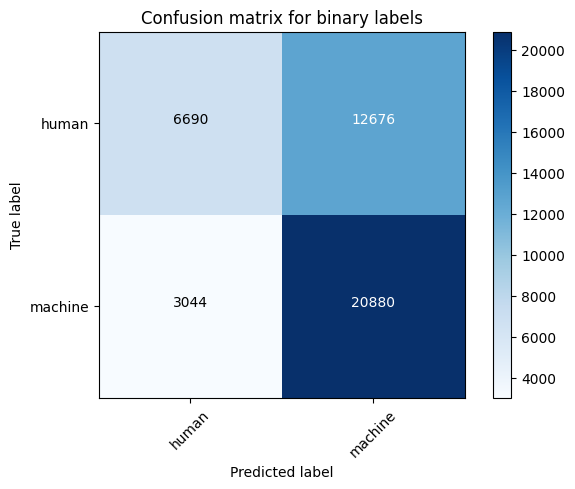

              precision    recall  f1-score   support

       human     0.6873    0.3455    0.4598     19366
     machine     0.6222    0.8728    0.7265     23924

    accuracy                         0.6369     43290
   macro avg     0.6548    0.6091    0.5932     43290
weighted avg     0.6513    0.6369    0.6072     43290

Test Accuracy: 0.6369
Test macro-F1: 0.5932



TRAINING condition: 'tf-idf-1' ==================
Dataset: '/home/lucas/Desktop/Personal/master_nlp/AplicacionesNLP/Tema_2/challenge/experiment_output/1_data_exploration/v1' ========
Total elements for train: 87513
Total elements for val: 21878
Total elements for test: 43290
Vectorizer class used: '<class 'sklearn.feature_extraction.text.TfidfVectorizer'>' with config: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preproce

In [ ]:
%%time
train_conditions: list[dict] = [
    {
        "name": "tf-1",
        "vectorizer": CountVectorizer(analyzer="word", ngram_range=(1, 1))
    },
    {
        "name": "tf-idf-1",
        "vectorizer": TfidfVectorizer(analyzer="word", norm="l2", ngram_range=(1, 1))
    },
]

xgboost_grid = {
    # "learning_rate": [0.01, 0.05, 0.1, 0.25, 0.5, 1],
    "learning_rate": [0.1],
    "n_estimators": [32, 64, 128, 256],
    "max_depth": [16, 32, 64]
}

for train_condition in train_conditions:
    condition_name: str = train_condition["name"]
    vectorizer = train_condition["vectorizer"]
    print(f"TRAINING condition: '{condition_name}' ==================")

    for dataset_folder in [dataset_v1_folder]:
        # TRAINING & VALIDATION ===============>
        print(f"Dataset: '{dataset_folder}' ========")
        x_y_data: dict = prepare_data_for_training(dataset_folder=dataset_folder)

        print(f"Vectorizer class used: '{type(vectorizer)}' with config: {vectorizer.get_params()}")

        # Initially, no feature selection
        for feature_selector in [SelectKBest(chi2, k=10000)]:
            feature_selector_params: dict = None if feature_selector is None else feature_selector.get_params()
            print(f"Feature selector class used: {type(feature_selector)} with config: {feature_selector_params} ===")
            model: MLClassifier = MLClassifier(estimator=xgb.XGBClassifier(tree_method="hist"),
                                               vectorizer=vectorizer,
                                               optimization_grid=xgboost_grid,
                                               feat_selector=feature_selector,
                                               verbosity=0)

            x_train, y_train, x_val, y_val, x_test, y_test = (
                x_y_data["x_train"], x_y_data["y_train"], x_y_data["x_val"],
                x_y_data["y_val"], x_y_data["x_test"], x_y_data["y_test"],)

            model.train(x_train=x_train,
                        y_train=y_train,
                        x_val=x_val,
                        y_val=y_val)
            # TESTING =================>
            model.predict_with_report(x_test=x_test, y_true=y_test)

I could train the classifier once and then run out of memory again.

In any case, the performance obtained is **59.32% of macro-f1**, which is still way worse than what we obtained with previos models.

In my opinion, it's worth to spend more time playing with transformed based architectures in the following notebook to see if we can get a more competitive result.

# Conclusions and Results

We conducted several experiments using different machine learning models. We focused primarily on algorithms that have historically demonstrated strong performance in text classification tasks, such as `SVMs`, `Logistic Regression`, and `XGBoost`.

Further conclusions:
- In general, using `tf-idf` with ngrams=(1,2) yields the best performance across all models. However, `tf` tends to perform better than `tf-idf` in some cases.
- 🏅 **LinearSVC**, with a 65.99% macro-f1, is the best model for MGT Detection.
- 🥈 **LogisticRegression**, with a 65.76% macro-f1, is the second best model for BINARY-CLASSIFICATION.
- 👎 In this case, algorithms like `Random Forests` or `XGBoost` had to be trained using feature selection, as otherwise 64GBs of CPU RAM didn't seem to be enough to complete the process. Notice that the performance achieved by them is really poor, even worse than our beloved Naive Bayes.
- 💡 Compared to some [of the results presented](https://sites.google.com/view/iberautextification/results?authuser=0) in the scoreboard, baselines obtained in this notebook seem to be okay.
- If inference speed in production is a critical factor, `LogisticRegression` would be the best choice. If we can tolerate slightly slower inference, `SVM` is, in my opinion, the overall winner for this initial experimentation.

The summary of the best results is shown in the following table.

---
| Notebook | Model            | Model Size | Dataset | Representation                                                    | Accuracy | Macro-Precision | Macro-Recall | Macro-F1   | Config Highlights                                                    |
|----------|-------------------|------------|---------|---------------------------------------------------------------------|----------|-----------------|--------------|------------|-----------------------------------------------------------------------|
| 2        | Naive Bayes       |            | v1      | BOW: tf<br>Level: word<br>N-grams: (1.1)                           | 0.6365   | 0.6368          | 0.6173       | 0.6128     | -                                                                     |
| 2        | LogisticRegression|            | v1      | BOW: tf-idf<br>Level: word<br>N-grams: (1.2)                       | 0.6755   | 0.6793          | 0.6587       | 0.6576     | (C=1000, max_iter=500, solver='liblinear')                          |
| 2        | LinearSVC         |            | v1      | BOW: tf-idf<br>Level: word<br>N-grams: (1.2)                       | 0.6767   | 0.6796          | 0.6606       | **0.6599** | (C=10)                                                              |
| 2        | RandomForests     |            | v1      | BOW: tf-idf<br>Level: word<br>N-grams: (1.2)<br>Method: chi2 - 20k | 0.6018   | 0.6507          | 0.5620       | 0.5074     | (max_depth=64, n_estimators=256, n_jobs=-1, random_state=999)       |
| 2        | XGBoost           |            | v1      | BOW: tf<br>Level: word<br>N-grams: (1.1)<br>Method: chi2 - 10k     | 0.6369   | 0.6548          | 0.6091       | 0.5932     | (learning_rate=0.1, max_depth=64, n_estimators=256)                 |
---

_The results from this notebook, along with others, can be viewed in the following [Google Spreadsheet](https://docs.google.com/spreadsheets/d/1fqPCRuKw_GooVeNqgcmIisXSTyrjyF10MfjwF-KUIyM/edit?gid=0#gid=0). For more information, refer to `4_results_and_conclusions.ipynb`, which also displays and summarizes our practice._
